# Costa Rican Household Poverty Level Prediction

또 다른 Kaggle 도전에 오신 것을 환영합니다! 코스타리카 가계 빈곤 수준 예측 대회의 목적은 개인의 특성과 가정의 특성을 모두 활용하여 가정의 빈곤 수준을 예측할 수 있는 머신러닝 모델을 개발하는 것입니다. 이 "선행을 위한 데이터 과학" 프로젝트는 사람들이 광고를 클릭하게 하는 것보다 사회에 더 유익한 일에 우리의 기술을 투입할 수 있는 기회를 제공합니다!

이 노트에서는 전체 머신러닝 솔루션에 대해 살펴보겠습니다. 먼저 문제를 소개하고, 데이터셋에 대한 철저한 탐색 데이터 분석을 수행하고, 기능 엔지니어링을 수행하고, 여러 머신러닝 모델을 사용해 보고, 모델을 선택하고, 모델을 최적화하고, 마지막으로 모델의 출력을 검사하고, 그리십시오. 

## Problem and Data Explanation

문제 및 데이터 설명입니다.
이 대회의 데이터는 train.csv와 test.csv의 두 가지 파일로 제공됩니다. 교육 세트에는 9557개의 행과 143개의 열이 있는 반면 검정 세트에는 23856개의 행과 142개의 열이 있습니다. 각 행은 한 개인을 나타내며, 각 열은 개인 또는 개인의 가정에 대한 특징입니다. 교육 세트에는 1-4 척도로 빈곤 수준을 나타내며 경쟁사의 레이블인 목표라는 추가 열이 있습니다. 1의 값은 극빈입니다.

이것은 감독되는 다중 클래스 분류 기계 학습 문제입니다.

감독: 교육 데이터의 레이블과 함께 제공됩니다.
다중 클래스 분류: 레이블은 4개의 클래스가 있는 이산형 값입니다.
객관적으로
목적은 빈곤을 가구 단위로 예측하는 것입니다. 우리는 개개인의 고유한 특징을 가진 개인 수준에 대한 데이터를 제공받지만 그들의 가계에 대한 정보도 제공합니다. 작업에 대한 데이터 세트를 만들려면 각 가구의 개별 데이터를 일부 집계해야 합니다. 게다가, 우리는 시험 세트에 있는 모든 개인에 대해 예측을 해야 하는데, "가장만 채점에 사용된다"는 것은 우리가 가구 단위로 빈곤을 예측하기를 원한다는 것을 의미합니다.

중요 사항: 교육 데이터에서 모든 가구원의 라벨은 동일해야 하지만, 동일한 가구원의 라벨이 서로 다른 오류가 있습니다. 이 경우 각 가구의 가장에 대한 레이블을 사용하도록 지시받았으며, 이 레이블은 parentesco1 == 1.0인 행으로 식별할 수 있습니다. 이 문제를 해결하는 방법은 노트에서 다루겠습니다(자세한 내용은 경쟁업체의 주요 논의를 참조하십시오).

- 1 = extreme poverty (극심한 빈곤)
- 2 = moderate poverty (적당한 빈곤)
- 3 = vulnerable households (취약계층)
- 4 = non vulnerable households (비취약 계층)



143개 열에 대한 설명은 경기 문서에서 확인할 수 있지만, 몇 가지 유의할 사항은 다음과 같습니다.

- ID : 각 개인에 대한 고유 식별자. 이 기능은 우리가 사용하는 기능이 아닙니다.
- idhogar : 각 가구의 고유 식별자입니다. 이 변수는 특징이 아니지만 한 가구의 모든 개인이 동일한 식별자를 갖게 되므로 가구별로 개인을 그룹화하는 데 사용됩니다.
- parentesco1 : 이 사람이 가장인지 여부를 나타냅니다.
- target : 한 가구의 모든 구성원에 대해 동일해야 하는 레이블입니다.

모델을 만들 때 각 가구당 가장의 빈곤수준을 표기한 라벨을 가지고 세대별로 교육할 것입니다. 원시 데이터에는 가구와 개인의 특성이 혼재되어 있는데 개별 데이터의 경우 가구별로 이를 집계할 수 있는 방법을 찾아야 할 것 같습니다. 개인들 중 일부는 가장이 없는 가정에 속해 있는데, 유감스럽게도 우리는 이 데이터를 훈련에 사용할 수 없습니다. 데이터와 관련된 이러한 문제는 실제 데이터에서 완전히 일반적인 문제이므로 데이터 과학 작업에서 발생할 데이터 세트를 준비하기에 적합합니다.

### Read in Data and Look at Summary Information


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
train.head()

Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_279628684  190000.0       0      3       0     1       1     0    NaN   
1  ID_f29eb3ddd  135000.0       0      4       0     1       1     1    1.0   
2  ID_68de51c94       NaN       0      8       0     1       1     0    NaN   
3  ID_d671db89c  180000.0       0      5       0     1       1     1    1.0   
4  ID_d56d6f5f5  180000.0       0      5       0     1       1     1    1.0   

   r4h1  r4h2  r4h3  r4m1  r4m2  r4m3  r4t1  r4t2  r4t3  tamhog  tamviv  \
0     0     1     1     0     0     0     0     1     1       1       1   
1     0     1     1     0     0     0     0     1     1       1       1   
2     0     0     0     0     1     1     0     1     1       1       1   
3     0     2     2     1     1     2     1     3     4       4       4   
4     0     2     2     1     1     2     1     3     4       4       4   

   escolari  rez_esc  hhsize  paredblolad  paredzocalo  paredpreb  pareddes  \
0        10      NaN       1            1            0          0         0   
1        12      NaN       1            0            0          0         0   
2        11      NaN       1            0            0          0         0   
3         9      1.0       4            1            0          0         0   
4        11      NaN       4            1            0          0         0   

   paredmad  paredzinc  paredfibras  paredother  pisomoscer  pisocemento  \
0         0          0            0           0           1            0   
1         1          0            0           0           0            0   
2         1          0            0           0           1            0   
3         0          0            0           0           1            0   
4         0          0            0           0           1            0   

   pisoother  pisonatur  pisonotiene  pisomadera  techozinc  techoentrepiso  \
0          0          0            0           0          0               1   
1          0          0            0           1          1               0   
2          0          0            0           0          1               0   
3          0          0            0           0          1               0   
4          0          0            0           0          1               0   

   techocane  techootro  cielorazo  abastaguadentro  abastaguafuera  \
0          0          0          1                1               0   
1          0          0          1                1               0   
2          0          0          1                1               0   
3          0          0          1                1               0   
4          0          0          1                1               0   

   abastaguano  public  planpri  noelec  coopele  sanitario1  sanitario2  \
0            0       1        0       0        0           0           1   
1            0       1        0       0        0           0           1   
2            0       1        0       0        0           0           1   
3            0       1        0       0        0           0           1   
4            0       1        0       0        0           0           1   

   sanitario3  sanitario5  sanitario6  energcocinar1  energcocinar2  \
0           0           0           0              0              0   
1           0           0           0              0              1   
2           0           0           0              0              1   
3           0           0           0              0              1   
4           0           0           0              0              1   

   energcocinar3  energcocinar4  elimbasu1  elimbasu2  elimbasu3  elimbasu4  \
0              1              0          1          0          0          0   
1              0              0          1          0          0          0   
2              0              0          1          0          0          0   
3              0              0          1          0

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


즉, 정수 열이 130개, 부동(숫자) 열이 8개, 객체 열이 5개 있습니다. 정수 열은 불변 변수(0 또는 1을 차지하는) 또는 이산형 순서 값을 갖는 순서형 변수를 나타냅니다. 객체 열은 기계 학습 모델에 직접 입력될 수 없기 때문에 문제가 될 수 있습니다.

열차보다 행(개체)이 더 많은 검정 데이터를 살펴보겠습니다. 대상이 없기 때문에 열이 하나 적습니다!

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


### Integer Columns

Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.



In [5]:
a=train.select_dtypes(np.int64).nunique().value_counts()
a

2     101
13      5
11      3
9       3
7       3
22      3
10      3
97      3
6       2
4       2
14      1
1       1
dtype: int64

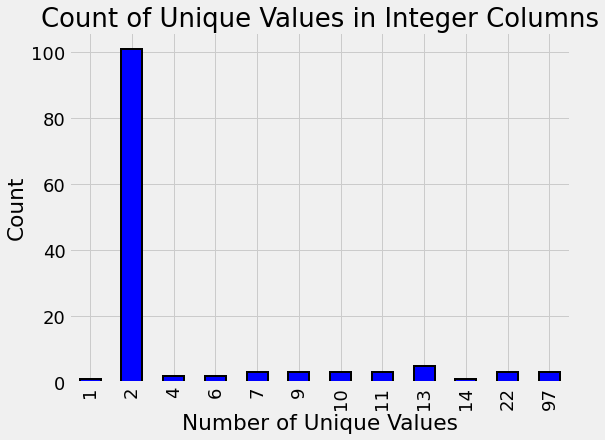

In [6]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

고유한 값이 2개만 있는 열은 부울란(0 또는 1)을 나타냅니다. 많은 경우, 이 불린 정보는 이미 가구 수준에 있습니다. 예를 들어, 냉장 칸에는 냉장고의 보유 여부가 표시됩니다. 가구 레벨에 있는 부울 컬럼에서 피쳐를 만들 시간이 되면 이를 집계할 필요가 없습니다. 그러나 개별 수준에 있는 부울 열을 집계해야 합니다.

### Float Columns

또 다른 열 유형은 연속형 변수를 나타내는 부동 소수입니다. 우리는 모든 부동 열의 분포를 보여주기 위해 빠른 분포도를 만들 수 있습니다. OrderedDict를 사용하여 부족 수준을 색상에 매핑합니다. 이렇게 하면 키와 값이 (일반 Python 사전과 달리) 지정한 순서에 따라 유지되기 때문입니다.

다음 그래프는 목표값으로 색상이 지정된 부동 열의 분포를 보여 줍니다. 이 그래프를 통해 가구의 빈곤 수준에 따라 변동 분포에 유의한 차이가 있는지 확인할 수 있습니다.

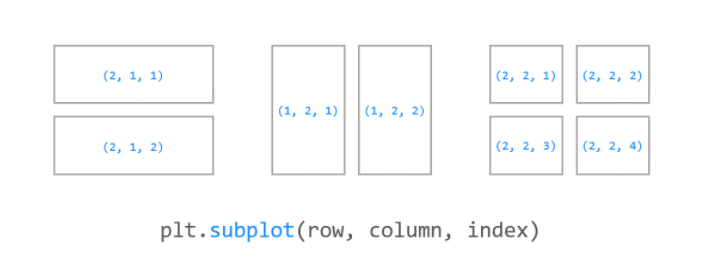

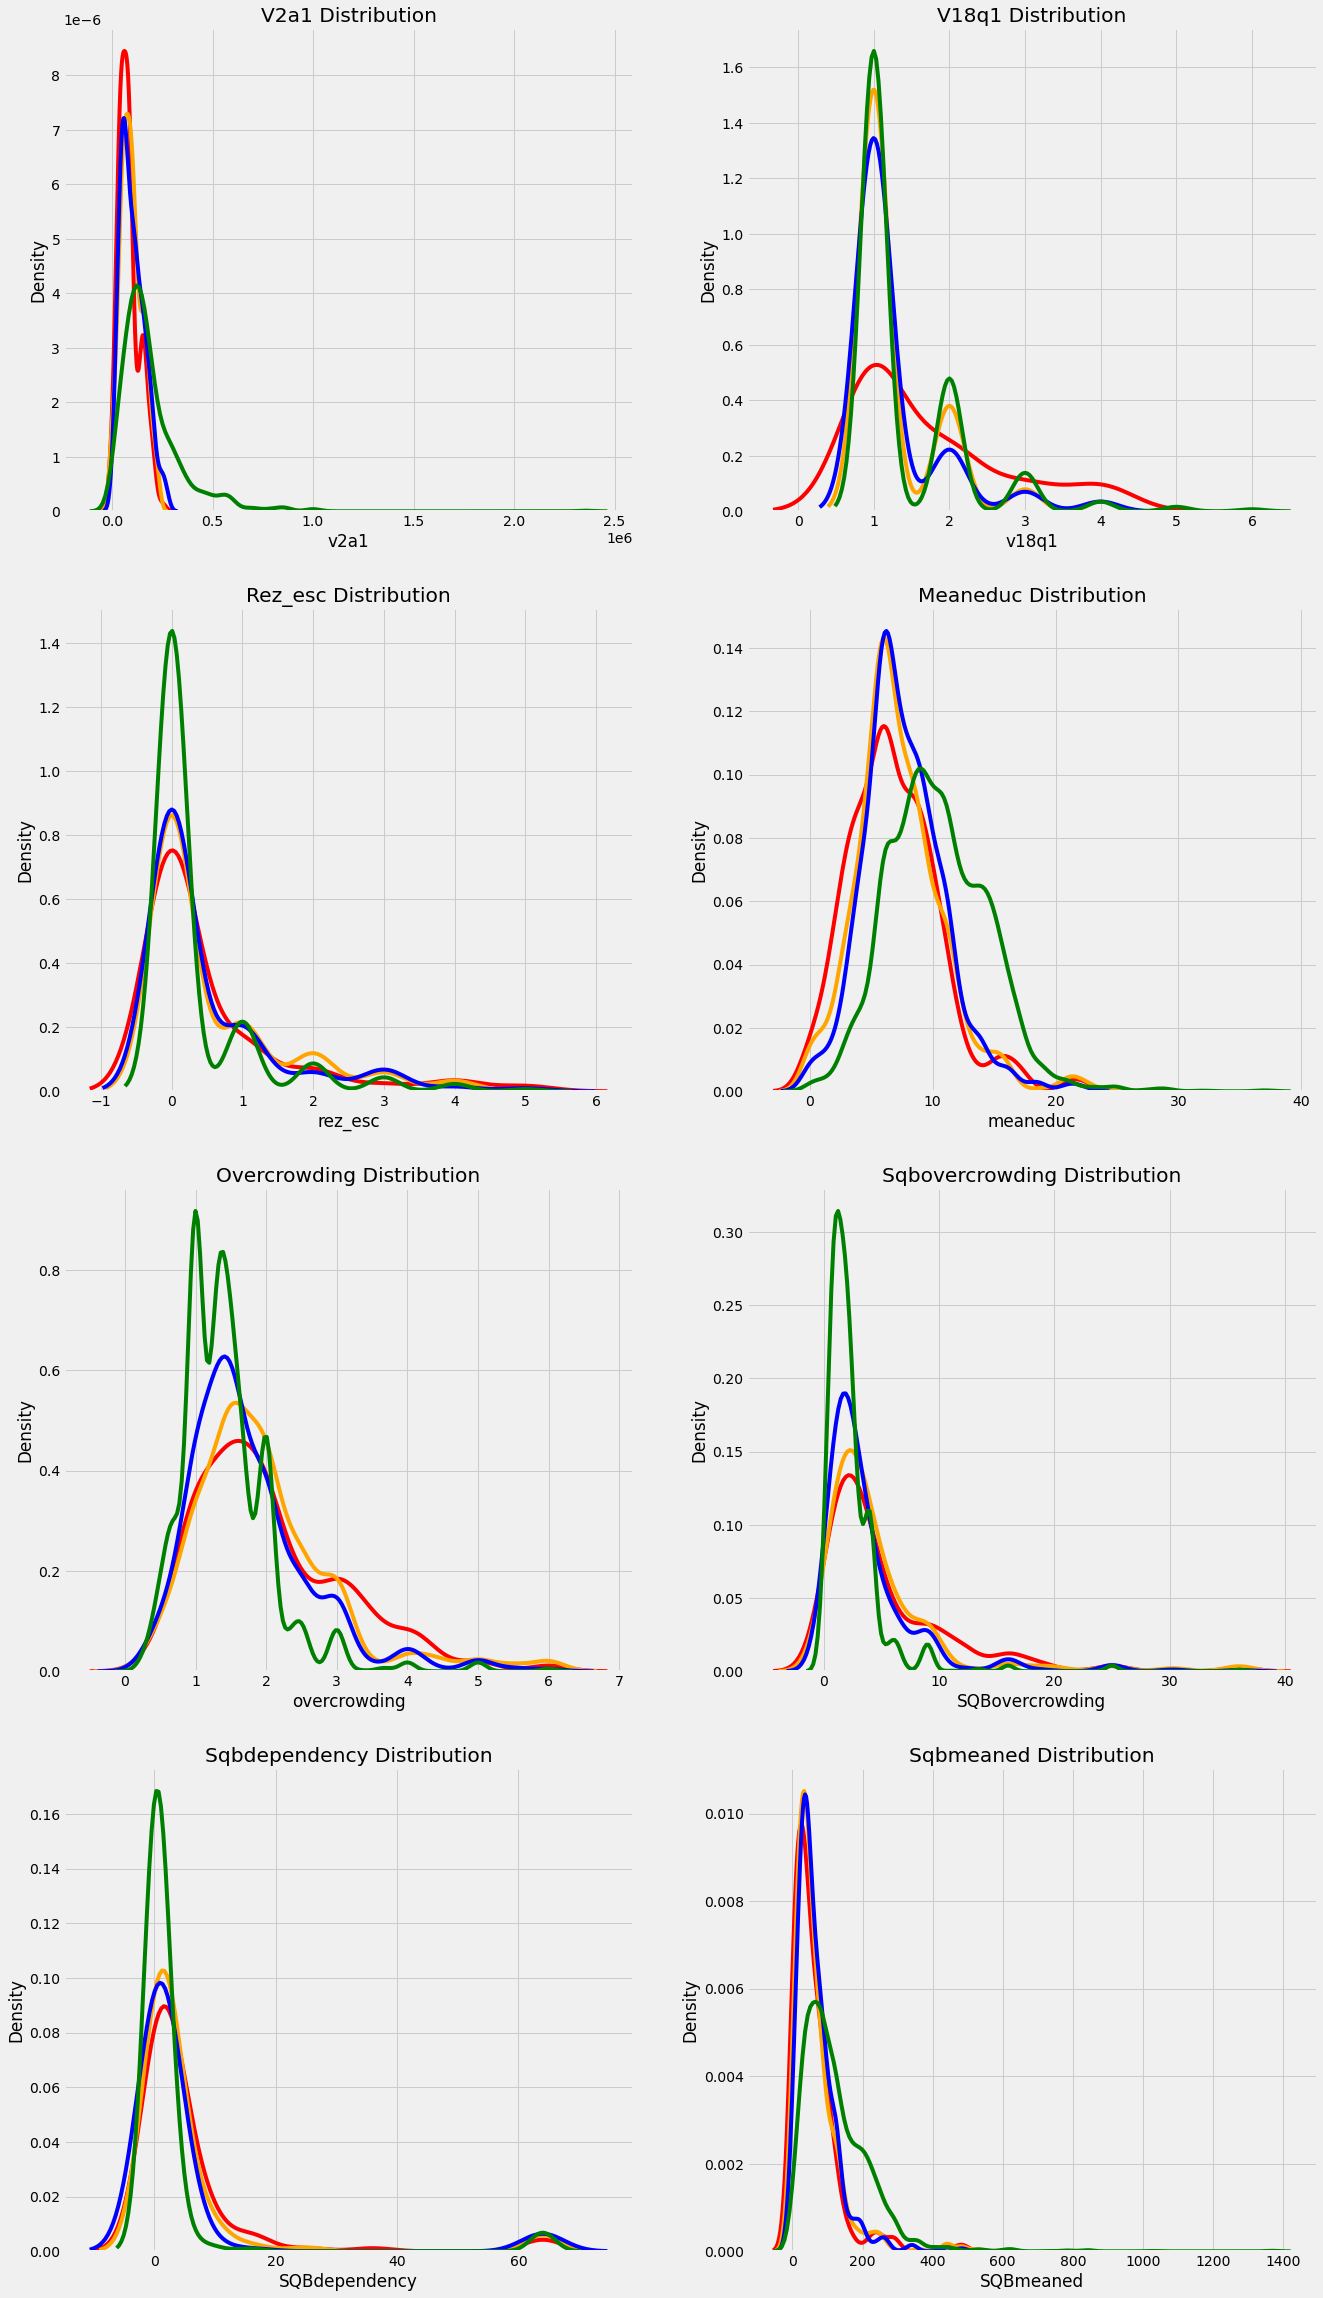

In [7]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight') # 스타일시트

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# x축
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # x축 일부(색상)
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [8]:
train.select_dtypes('float')

v2a1  v18q1  rez_esc  meaneduc  overcrowding  SQBovercrowding  \
0     190000.0    NaN      NaN     10.00      1.000000         1.000000   
1     135000.0    1.0      NaN     12.00      1.000000         1.000000   
2          NaN    NaN      NaN     11.00      0.500000         0.250000   
3     180000.0    1.0      1.0     11.00      1.333333         1.777778   
4     180000.0    1.0      NaN     11.00      1.333333         1.777778   
...        ...    ...      ...       ...           ...              ...   
9552   80000.0    NaN      NaN      8.25      1.250000         1.562500   
9553   80000.0    NaN      NaN      8.25      1.250000         1.562500   
9554   80000.0    NaN      NaN      8.25      1.250000         1.562500   
9555   80000.0    NaN      NaN      8.25      1.250000         1.562500   
9556   80000.0    NaN      NaN      8.25      1.250000         1.562500   

      SQBdependency  SQBmeaned  
0            0.0000   100.0000  
1           64.0000   144.0000  
2           64.0000   121.0000  
3            1.0000   121.0000  
4            1.0000   121.0000  
...             ...        ...  
9552         0.0625    68.0625  
9553         0.0625    68.0625  
9554         0.0625    68.0625  
9555         0.0625    68.0625  
9556         0.0625    68.0625  

[9557 rows x 8 columns]

나중에 변수와 목표값 사이의 상관 관계를 계산하여 형상 간의 관계를 측정하겠지만, 이러한 그림을 통해 모형과 가장 "관련성 있는" 변수가 무엇인지 알 수 있습니다. 예를 들어, 가구 내 성인의 평균 교육을 나타내는 평균 교육은 빈곤 수준과 관련이 있는 것으로 보입니다: 높은 평균 성인 교육은 목표의 높은 가치로 이어지고 덜 심각한 빈곤 수준으로 이어집니다. 교육의 중요성에 대한 주제는 우리가 이 공책에서 계속해서 다시 보게 될 주제입니다!

### Object Columns


In [9]:
train.select_dtypes('object').head()

Id    idhogar dependency edjefe edjefa
0  ID_279628684  21eb7fcc1         no     10     no
1  ID_f29eb3ddd  0e5d7a658          8     12     no
2  ID_68de51c94  2c7317ea8          8     no     11
3  ID_d671db89c  2b58d945f        yes     11     no
4  ID_d56d6f5f5  2b58d945f        yes     11     no

마지막 열 type은 아래와 같이 볼 수 있는 'object'입니다.

Id 및 idhogar 개체 유형은 식별 변수이므로 의미가 있습니다. 
그러나 나머지 열은 기계 학습을 수행하기 전에 해결해야 할 문자열과 숫자가 혼합된 것으로 보입니다. 

- dependency : 종속율, =(19세 미만 가구원 수)/(19~64세 가구원 수)

- edjefe : 남성 가장의 교육 연수는 에스콜라리(교육 연수), 세대주 및 성별 상호 작용을 기반으로 합니다(예=1 및 아니오=0).

- edjefa : 여성 가장의 교육 연수는 에스콜라리(교육 연수), 세대주 및 성별 상호 작용을 기반으로 합니다(예=1 및 아니오=0).

이러한 설명으로 문제가 해결되었습니다. 이 세 변수의 경우 "예" = 1 및 "아니오" = 0입니다. 매핑을 사용하여 변수를 수정하고 부동 변수로 변환할 수 있습니다.

In [10]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

dependency       edjefa       edjefe
count  9557.000000  9557.000000  9557.000000
mean      1.149550     2.896830     5.096788
std       1.605993     4.612056     5.246513
min       0.000000     0.000000     0.000000
25%       0.333333     0.000000     0.000000
50%       0.666667     0.000000     6.000000
75%       1.333333     6.000000     9.000000
max       8.000000    21.000000    21.000000

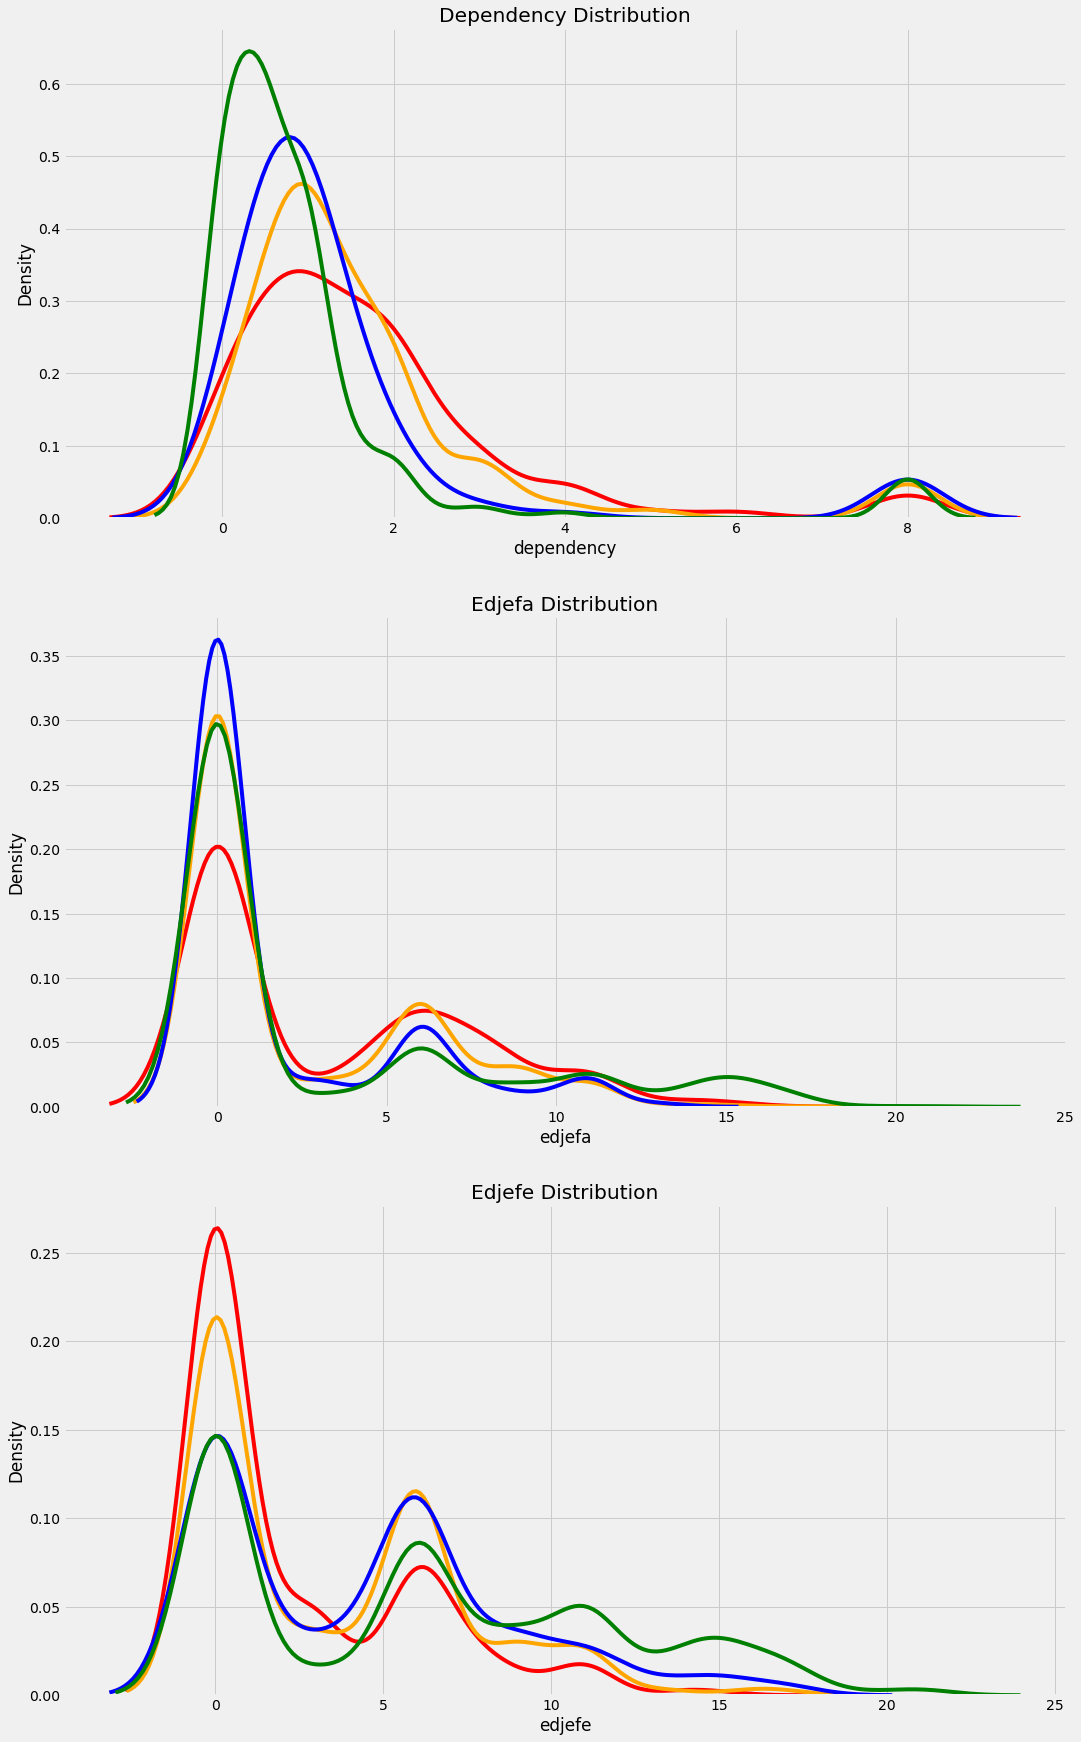

In [11]:
plt.figure(figsize = (16, 12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [12]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

## Exploring Label Distribution

다음으로 레이블 분포를 보면 얼마나 불균형적인 문제인지 알 수 있습니다. 4가지 가능한 정수 수준이 있는데, 이것은 빈곤의 4가지 수준을 나타냅니다.
올바른 레이블을 보려면 parentesco1 == 1인 열에만 부분 집합을 취합니다. 이 열은 '가장'인 레이블이기 때문입니다. (식구 4명 빈곤 -> 가장 1명 빈곤)

아래 막대 그림은 (검정 레이블이 없으므로) 교육용 레이블의 분포를 보여줍니다.

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

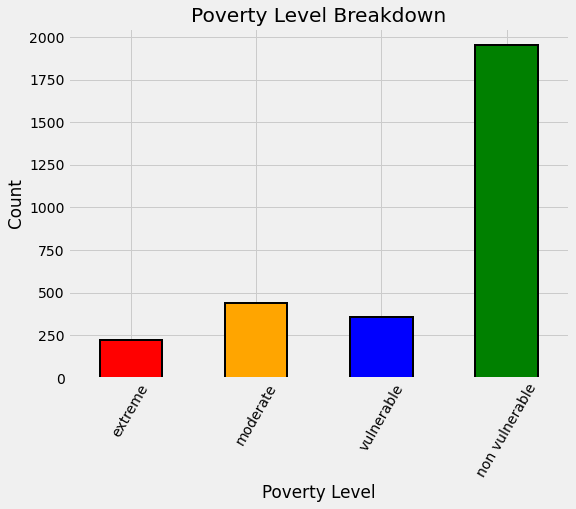

In [13]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']] # df.loc[row, columns]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

label_counts

In [14]:
data['parentesco1'] == 1

0         True
1         True
2         True
3        False
4        False
         ...  
33408    False
33409     True
33410    False
33411    False
33412    False
Name: parentesco1, Length: 33413, dtype: bool

In [15]:
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]
train_labels

Target    idhogar
0        4.0  21eb7fcc1
1        4.0  0e5d7a658
2        4.0  2c7317ea8
5        4.0  2b58d945f
8        4.0  d6dae86b7
...      ...        ...
9535     1.0  9bbf7c6ca
9541     2.0  e87e70c06
9545     4.0  a8eeafc29
9551     2.0  212db6f6c
9552     2.0  d6c086aa3

[2973 rows x 2 columns]

In [16]:
label_counts = train_labels['Target'].value_counts().sort_index()
label_counts

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

우리는 불균형 클래스 문제를 다루고 있습니다(대회 주최자가 weighted F1 대신 marco F1 점수를 메트릭으로 선택하는 이유는 매우 흥미롭습니다). 취약계층으로 분류하는 가구가 다른 어떤 범주보다 훨씬 많습니다. 극빈층이 가장 작습니다.

불균형 분류 문제의 한 가지 문제는 머신러닝 모델이 훨씬 적은 예를 보기 때문에 소수 수업을 예측하는 데 어려움을 겪을 수 있다는 것입니다. 이것을 인간의 관점에서 생각해보세요: 만약 우리가 빈곤을 분류하고 있고, 극심한 빈곤보다 빈곤이 없는 경우를 훨씬 더 많이 본다면, 우리는 더 적은 노출 때문에 높은 빈곤 가구를 식별하는 것을 더 어렵게 만들 것입니다. 클래스 불균형을 해결할 수 있는 한 가지 잠재적인 방법은 오버샘플링을 사용하는 것입니다(고급 노트북에서 다루어짐).

## Addressing Wrong Labels

다른 현실적인 데이터 세트와 마찬가지로 코스타리카 빈곤 데이터에도 몇 가지 문제가 있습니다. 일반적으로 데이터 과학 프로젝트의 80%는 데이터를 정리하고 이상 징후/오류를 수정하는 데 사용됩니다. 이는 사람 입력 오류, 측정 오류 또는 정확하지만 눈에 띄는 극단값일 수 있습니다. 이 문제에 대해, 같은 가정의 개인들은 다른 빈곤 수준을 가지고 있기 때문에 일부 라벨은 정확하지 않습니다. 왜 그럴지도 모르지만 가장을 진짜 꼬리표로 쓰라고 했습니다.

그 정보가 우리의 일을 훨씬 쉽게 만들어 주지만, 실제 문제에서 우리는 왜 라벨이 잘못되었는지, 그리고 그 문제를 스스로 해결할 수 있는 방법을 알아내야 할 것입니다. 이 섹션에서는 레이블의 문제를 수정할 필요는 없지만, 이 문제를 어떻게 처리할 수 있는지 보여주기 위해 노트에 보관했습니다.


### Identify Errors

먼저 오류를 찾아 수정해야 합니다. 가족 구성원의 레이블이 다른 가구를 찾기 위해 가구별로 데이터를 그룹화한 다음 대상의 고유 값이 하나만 있는지 확인할 수 있습니다.


In [17]:
# True면 가족 모두 빈곤수준={1,2,3,4} 중 하나로 통일함, False면 빈곤수준={1,2,3,4} 중 2개 이상이 존재
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
all_equal

idhogar
001ff74ca    True
003123ec2    True
004616164    True
004983866    True
005905417    True
             ... 
ff9343a35    True
ff9d5ab17    True
ffae4a097    True
ffe90d46f    True
fff7d6be1    True
Name: Target, Length: 2988, dtype: bool

In [18]:
# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


한 가지 예를 살펴보겠습니다.


In [19]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

idhogar  parentesco1  Target
7651  0172ab1d9            0       3
7652  0172ab1d9            0       2
7653  0172ab1d9            0       3
7654  0172ab1d9            1       3
7655  0172ab1d9            0       2

주최 측은 올바른 라벨이 가장의 라벨이며, 여기서 parentesco1 == 1이라고 말합니다. 이 가구의 경우, 올바른 라벨은 모든 구성원을 위한 3입니다. 우리는 이 가정의 모든 사람들을 올바른 빈곤 수준으로 재할당함으로써 (나중에 보여지는 것처럼) 이것을 바로잡을 수 있습니다. 실제 상황에서는 혼자서(또는 팀의 도움을 받아) 문제를 해결하는 어려운 결정을 내려야 할 수도 있습니다.


### Families without Heads of Household

우리는 같은 가구에 있는 개인에게 가장의 라벨을 지정함으로써 라벨 불일치를 수정할 수 있습니다. 하지만, 여러분은 이렇게 물을지도 모릅니다: "만약 가장이 없는 가정이 있다면요? 그리고 만약 그 가구 구성원들의 라벨에 대한 가치관이 다르면 어떻게 될까요?"

그럼, 당신이 물었으니, 그 질문을 정확히 조사해보죠!



In [20]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()
households_leader

idhogar
001ff74ca    1
003123ec2    1
004616164    1
004983866    1
005905417    1
            ..
ff9343a35    1
ff9d5ab17    1
ffae4a097    1
ffe90d46f    1
fff7d6be1    1
Name: parentesco1, Length: 2988, dtype: int64

In [21]:
# 가장이 없는 그룹리스트
households_leader[households_leader == 0].index

Index(['03c6bdf85', '09b195e7a', '1367ab31d', '1bc617b23', '374ca5a19',
       '61c10e099', '6b1b2405f', '896fe6d3e', 'a0812ef17', 'ad687ad89',
       'b1f4d89d7', 'bfd5067c2', 'c0c8a5013', 'd363d9183', 'f2bfa75c4'],
      dtype='object', name='idhogar')

In [22]:
# 가장이 없는 그룹데이터프레임
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :] 
households_no_head

Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  \
4935  ID_717302050       NaN       0      8       0     1       1     0   
4975  ID_ff6f13458       NaN       0      4       0     1       1     0   
5391  ID_64c9eabac       NaN       0      5       0     1       1     0   
5396  ID_8948b1f91   90000.0       0      5       0     1       1     0   
6443  ID_8ddb34d2c       NaN       0      3       0     1       1     0   
6444  ID_03e2f23b0       NaN       0      3       0     1       1     0   
7086  ID_ba2ac56bb       NaN       0      4       0     1       1     0   
7438  ID_7ba374a80       NaN       0      4       0     1       1     0   
7439  ID_1bca5b5e5       NaN       0      4       0     1       1     0   
7440  ID_622be4200       NaN       0      4       0     1       1     0   
7461  ID_1f91daf92  150000.0       1      3       0     0       1     0   
7462  ID_686d2639f  150000.0       1      3       0     0       1     0   
7463  ID_b84170356  150000.0       1      3       0     0       1     0   
7705  ID_c7c038825   58731.0       0      3       0     1       1     0   
7706  ID_ebef0991f   58731.0       0      3       0     1       1     0   
7756  ID_f81c03ca9       NaN       0      5       0     1       0     0   
7757  ID_c792d2a9b       NaN       0      4       0     1       1     0   
8431  ID_0f75a20b2       NaN       0      4       0     1       1     0   
8432  ID_dfab56985       NaN       0      4       0     1       1     0   
8433  ID_82ebed6d4       NaN       0      4       0     1       1     0   
8636  ID_a6e897e47       NaN       0      4       0     1       1     0   
9489  ID_7788ff3e2       NaN       0      4       0     1       1     0   
9497  ID_60c0ce2d4       NaN       0      4       0     1       1     0   

      v18q1  r4h1  r4h2  r4h3  r4m1  r4m2  r4m3  r4t1  r4t2  r4t3  tamhog  \
4935    NaN     0     2     2     0     2     2     0     4     4       4   
4975    NaN     1     1     2     0     2     2     1     3     4       4   
5391    NaN     0     1     1     0     2     2     0     3     3       3   
5396    NaN     2     1     3     1     1     2     3     2     5       5   
6443    NaN     1     1     2     0     2     2     1     3     4       4   
6444    NaN     1     1     2     0     2     2     1     3     4       4   
7086    NaN     0     1     1     2     2     4     2     3     5       5   
7438    NaN     0     3     3     0     1     1     0     4     4       4   
7439    NaN     0     3     3     0     1     1     0     4     4       4   
7440    NaN     0     3     3     0     1     1     0     4     4       4   
7461    NaN     2     2     4     1     1     2     3     3     6       6   
7462    NaN     2     2     4     1     1     2     3     3     6       6   
7463    NaN     2     2     4     1     1     2     3     3     6       6   
7705    NaN     1     1     2     2     1     3     3     2     5       5   
7706    NaN     1     1     2     2     1     3     3     2     5       5   
7756    NaN     1     2     3     0     2     2     1     4     5       5   
7757    NaN     1     1     2     0     1     1     1     2     3       3   
8431    NaN     1     2     3     1     1     2     2     3     5       5   
8432    NaN     1     2     3     1     1     2     2     3     5       5   
8433    NaN     1     2     3     1     1     2     2     3     5       5   
8636    NaN     0     1     1     0     2     2     0     3     3       3   
9489    NaN     0     3     3     1     1     2     1     4     5       5   
9497    NaN     0     3     3     0     1     1     0     4     4       4   

      tamviv  escolari  rez_esc  hhsize  paredblolad  paredzocalo  paredpreb  \
4935       4         6      NaN       4            0            0          0   
4975       4         9      0.0       4            1            0          0   
5391       3        14      NaN       3            1            0          0   
5396       5         3      0.0       5       

In [23]:
# 가장이 없는 가구 수
print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [24]:
# 가장이 없는 가구 & 빈곤수준을 다르게 한 가구
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


다행이네요! 이것은 머리도 없고 멤버들의 라벨 가치도 다른 가정을 걱정할 필요가 없다는 것을 의미해요! 주최자들에 따르면, 만약 한 가정에 가장이 없다면, 진정한 라벨은 없는 것이라고 합니다. 그러므로, 우리는 사실 가장이 없는 어떤 가정도 훈련에 사용하지 않을 것입니다. 그럼에도 불구하고, 이 데이터 조사 과정을 거치는 것은 여전히 좋은 연습입니다!


### Correct Errors

이제 우리는 가장이 있는 가구와 구성원의 빈곤 수준이 다른 가구들에 대한 라벨을 수정할 수 있습니다.



In [25]:
# 빈곤 수준을 다르게 적은 가구
not_equal.index

Index(['0172ab1d9', '03f4e5f4d', '0511912b6', '078a0b6e2', '09e25d616',
       '0f3e65c83', '0f9494d3a', '15a891635', '17fb04a62', '18832b840',
       '26b3a0f41', '288579c97', '28893b5e7', '2c9872b82', '2cb443214',
       '309fb7246', '30a70901d', '3c6973219', '3c73c107f', '3df651058',
       '3fe29a56b', '410194c8b', '417865404', '42ec8bef5', '43b9c83e5',
       '44f219a16', '46af47063', '4b6077882', '4c2dba109', '4dc11e11f',
       '4e19bd549', '50e064ee8', '513adb616', '54118d5d9', '55a662731',
       '564eab113', '594d3eb27', '5c3f7725d', '5c6f32bbc', '5e9329fc6',
       '614b48fb7', '636330516', '654ef7612', '67ad49822', '6833ac5dc',
       '694a0cbf4', '6a389f3de', '6bcf799cf', '6c543442a', '71cd52a80',
       '73d85d05d', '7ad269eef', '7c57f8237', '7e9d58c5c', '7ea6aca15',
       '80a66379b', '811a35744', '8242a51ec', '8420bcfca', '8ae3e74ca',
       '8bb6da3c1', '932287f5d', '9bbf7c6ca', 'a20ff33ba', 'a3288e6fa',
       'a94a45642', 'bcaa2e2f5', 'bcab69521', 'bd82509d1', 'be91

In [26]:
# Iterate through each household
for household in not_equal.index:
    # 빈곤수준을 다르게 적은 가구의 가장의 빈곤수준
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # 빈곤수준을 통일
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


라벨에는 가장만 사용할 예정이기 때문에 이 단계가 꼭 필요한 것은 아니지만 실제 발생할 수 있는 데이터 오류를 수정하기 위한 워크플로를 보여줍니다. 야근이라고 생각하지 말고 경력을 위해 연습하세요!


## Missing Variables

먼저 각 열의 결측값 백분율을 살펴볼 수 있습니다.


In [27]:
data.isnull().sum()

Id                     0
v2a1               24263
hacdor                 0
rooms                  0
hacapo                 0
                   ...  
SQBovercrowding        0
SQBdependency          0
SQBmeaned             36
agesq                  0
Target             23856
Length: 143, dtype: int64

In [28]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data) # 33413:nrow

missing.sort_values('percent', ascending = False).head(10).drop('Target')

total   percent
rez_esc       27581  0.825457
v18q1         25468  0.762218
v2a1          24263  0.726154
SQBmeaned        36  0.001077
meaneduc         36  0.001077
hogar_adul        0  0.000000
parentesco10      0  0.000000
parentesco11      0  0.000000
parentesco12      0  0.000000


테스트 데이터를 위해 NaN을 만들었기 때문에 Target에 대해서는 걱정하지 않아도 됩니다. 그러나 결측값 비율이 높은 나머지 3개 열을 처리해야 합니다.

#### rez_esc : rez_esc는 7세에서 19세 사이의 인구 중 입학에 늦는 연수를 의미한다. (8살에 입학해야했는데 11살에 입학했다면 rez_esc=3)
#### v2a1 : 월세



### v18q1: 태블릿 수입니다.
    
가족이 소유한 태블릿의 수를 나타내는 v18q1부터 시작하겠습니다.</br>
우리는 이 변수의 값 개수를 볼 수 있습니다.</br>
이것은 가계 변수이기 때문에 가구 단위로만 보는 것이 타당하기 때문에 가장의 행만 선정하도록 하겠습니다.


### Function to Plot Value Counts

서로 다른 열에 대한 값 수를 플롯할 수 있으므로 이러한 작업을 수행할 수 있는 간단한 함수를 작성할 수 있습니다!


In [29]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

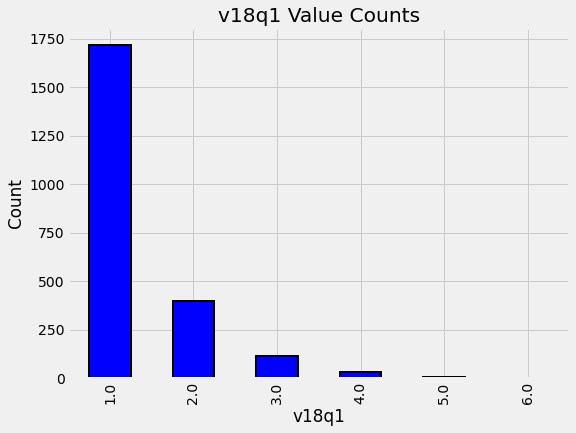

In [30]:
plot_value_counts(heads, 'v18q1')

존재하는 데이터만 기준으로 계산하면 태블릿을 가장 많이 보유하는 것이 1대인 것 같습니다. 하지만 우리는 누락된 데이터도 생각해야 합니다. 이 경우, 이 범주에 속하는 nan를 가진 가정들은 태블릿을 가지고 있지 않을 수도 있습니다! 데이터 정의를 살펴보면 v18q가 태블릿을 소유하고 있는지 여부를 나타냅니다. 우리는 우리의 가설이 들어맞는지 확인하기 위해 이 열을 태블릿의 수와 결합해서 조사해야 합니다.

v18q 값(태블릿 소유의 경우 1이고 소유하지 않는 경우 0)을 기준으로 그룹화한 다음 v18q1의 null 값 수를 계산할 수 있습니다. 이것은 null 값이 가족이 태블릿을 소유하지 않음을 나타내는지 알려줍니다.

In [31]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

그럼 문제가 해결됐네요! v18q1용 nan을 보유한 모든 제품군은 태블릿을 소유하지 않습니다. 따라서 우리는 이 결측값을 0으로 채울 수 있습니다.


In [32]:
data['v18q1'] = data['v18q1'].fillna(0)

### v2a1: 월세

다음 누락 열은 v2a1로 월세 지불을 나타냅니다.

월세 결제의 결측값뿐만 아니라 주택 소유/임대 현황을 보여주는 열인 tipovivi_ 분포도 살펴볼 수 있어 흥미로울 것입니다. 이 플롯에서는 월세 지불을 위한 nan로 주택의 소유권 상태를 보여줍니다.

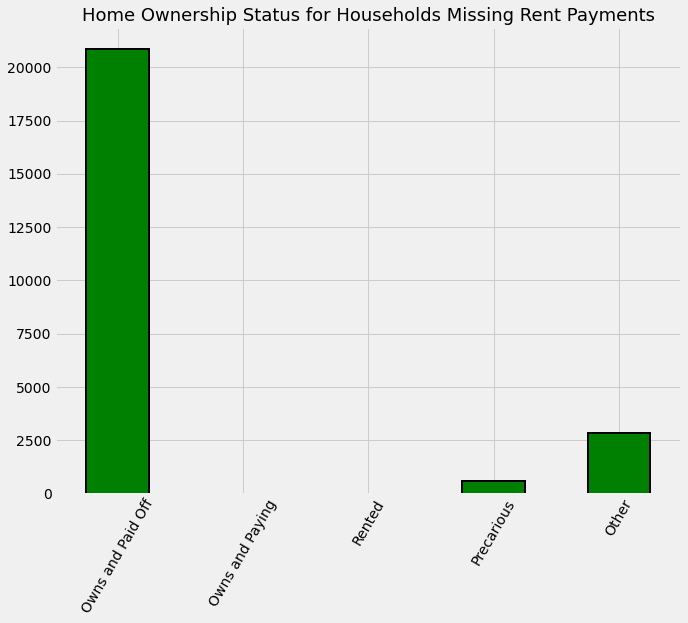

In [33]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

tipovivi1 =1 소유 및 완전 지불 주택입니다.</br>
tipovivi2, "=1 소유, 분할 지불"입니다.</br>
tipovivi3, =1 임대되었습니다.</br>
tipovivi4, =1 불안정합니다.</br>
tipovivi5, "=1 기타(기타, 대여)"입니다.

보유 주택 중 월세 납부가 누락된 주택에 대해서는 월세 납입가액을 0으로 설정할 수 있습니다. 다른 주택의 경우 결측값은 귀속시킬 수 있지만 이 가구에는 결측값이 있었다는 것을 나타내는 깃발(부울) 열을 추가할 것입니다.


In [34]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

### rez_esc: rez_esc는 7세에서 19세 사이의 인구 중 입학에 늦는 연수를 의미한다. (8살에 입학해야했는데 11살에 입학했다면 rez_esc=3)

null이면 자녀가 없다.
결측값 비율이 높은 마지막 열은 rez_esc로 학년 뒤처짐을 나타냅니다. 값이 무효인 가정의 경우 현재 학교에 자녀가 없을 가능성이 있습니다. 이 열에 결측값이 있는 사람의 연령과 결측값이 없는 사람의 연령을 찾아 이를 테스트해 보겠습니다.



In [35]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

이것이 말해주는 것은 결측값을 가진 가장 나이가 많은 나이는 17세라는 것입니다. 
이것보다 나이가 더 많은 사람이라면, 우리는 그들이 단순히 학교에 있지 않다고 추측할 수 있을 것입니다. 
결손치가 있는 사람들의 나이를 살펴봐요.


In [36]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

In [37]:
data['rez_esc'].value_counts()

0.0     4474
1.0      728
2.0      336
3.0      174
4.0       80
5.0       39
99.0       1
Name: rez_esc, dtype: int64

이 대회에 대한 몇 가지 논의를 살펴보면 이 변수가 7-19세 사이의 개인에게만 정의되어 있음을 알 수 있습니다. 이 범위보다 어리거나 오래된 사람은 년 수가 없으므로 값을 0으로 설정해야 합니다. 이 변수의 경우, 개인이 19세 이상이고 결측치가 있는 경우 또는 7세 미만이고 결측치가 있는 경우 0으로 설정할 수 있습니다. 다른 사용자의 경우 귀속 값을 그대로 두고 부울 플래그를 추가합니다.


In [38]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

rez_esc 열에는 특이치도 하나 있습니다. 다시 경쟁 토론 내용을 살펴보면 이 변수의 최대값이 5라는 것을 알 수 있습니다. 따라서 5를 초과하는 값은 5로 설정해야 합니다.


In [39]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

## Plot Two Categorical Variables

두 범주형 변수가 서로 교호작용하는 방식을 보여 주기 위해 산점도, 면 막대 그림, 상자 그림 등 여러 가지 표시 옵션이 있습니다.

저는 이러한 선택 중 어느 것도 만족하지 못했기 때문에 아래에 함수를 작성했는데, 이 함수는 기본적으로 점의 크기가 각 x-값으로 표현되는 주어진 y-값의 백분율을 나타내는 두 개의 범주형 산점도입니다.



In [40]:
raw_counts = pd.DataFrame(data.groupby('Target')['rez_esc'].value_counts(normalize = False))
raw_counts = raw_counts.rename(columns = {'rez_esc' : 'raw_count'})
raw_counts

raw_count
Target rez_esc           
1.0    0.0            682
       1.0             27
       2.0             12
       4.0              6
       3.0              4
       5.0              3
2.0    0.0           1405
       1.0             64
       2.0             36
       3.0             18
       4.0             10
       5.0              1
3.0    0.0           1093
       1.0             41
       3.0             14
       2.0             12
       4.0              3
       5.0              2
4.0    0.0           5609
       1.0             95
       2.0             38
       3.0             19
       4.0             10
       5.0              3

In [41]:
counts = pd.DataFrame(data.groupby('Target')['rez_esc'].value_counts(normalize = True))

# Rename the column and reset the index
counts = counts.rename(columns = {'rez_esc': 'normalized_count'}).reset_index()
counts['percent'] = 100 * counts['normalized_count']
counts

Target  rez_esc  normalized_count    percent
0      1.0      0.0          0.929155  92.915531
1      1.0      1.0          0.036785   3.678474
2      1.0      2.0          0.016349   1.634877
3      1.0      4.0          0.008174   0.817439
4      1.0      3.0          0.005450   0.544959
5      1.0      5.0          0.004087   0.408719
6      2.0      0.0          0.915906  91.590613
7      2.0      1.0          0.041721   4.172099
8      2.0      2.0          0.023468   2.346806
9      2.0      3.0          0.011734   1.173403
10     2.0      4.0          0.006519   0.651890
11     2.0      5.0          0.000652   0.065189
12     3.0      0.0          0.938197  93.819742
13     3.0      1.0          0.035193   3.519313
14     3.0      3.0          0.012017   1.201717
15     3.0      2.0          0.010300   1.030043
16     3.0      4.0          0.002575   0.257511
17     3.0      5.0          0.001717   0.171674
18     4.0      0.0          0.971424  97.142362
19     4.0      1.0          0.016453   1.645307
20     4.0      2.0          0.006581   0.658123
21     4.0      3.0          0.003291   0.329061
22     4.0      4.0          0.001732   0.173190
23     4.0      5.0          0.000520   0.051957

In [42]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

C:\Users\HOME\AppData\Local\Temp/ipykernel_11492/4119447328.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy = (row[x] - (1 / counts[x].nunique()),


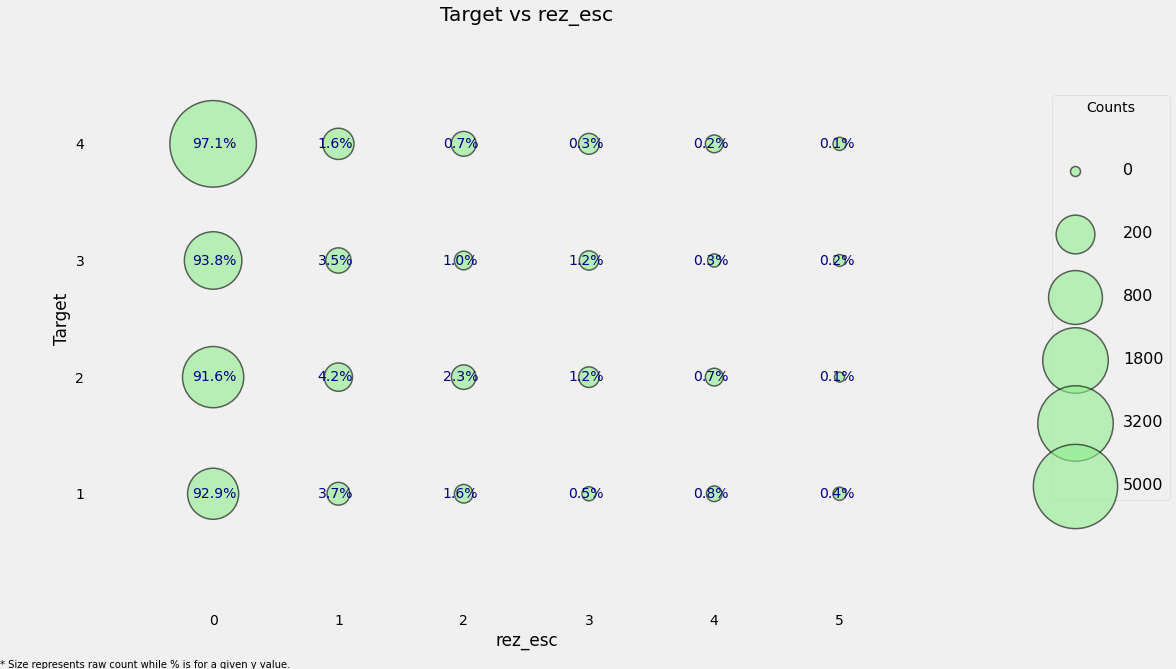

In [43]:
plot_categoricals('rez_esc', 'Target', data);

마커의 크기는 원시 카운트를 나타냅니다. 그림을 읽으려면 주어진 y 값을 선택한 다음 행을 가로질러 읽습니다. 예를 들어, 빈곤 수준이 1인 경우, 총 800여 명으로 93%의 개인이 연차가 없으며, 약 0.4%의 개인이 5년 뒤처져 약 50명이 이 범주에 속합니다. 이 줄거리는 전체 카운트와 범주 내 비율을 모두 표시하려고 합니다. 완벽하지는 않지만 시도해 보았습니다!


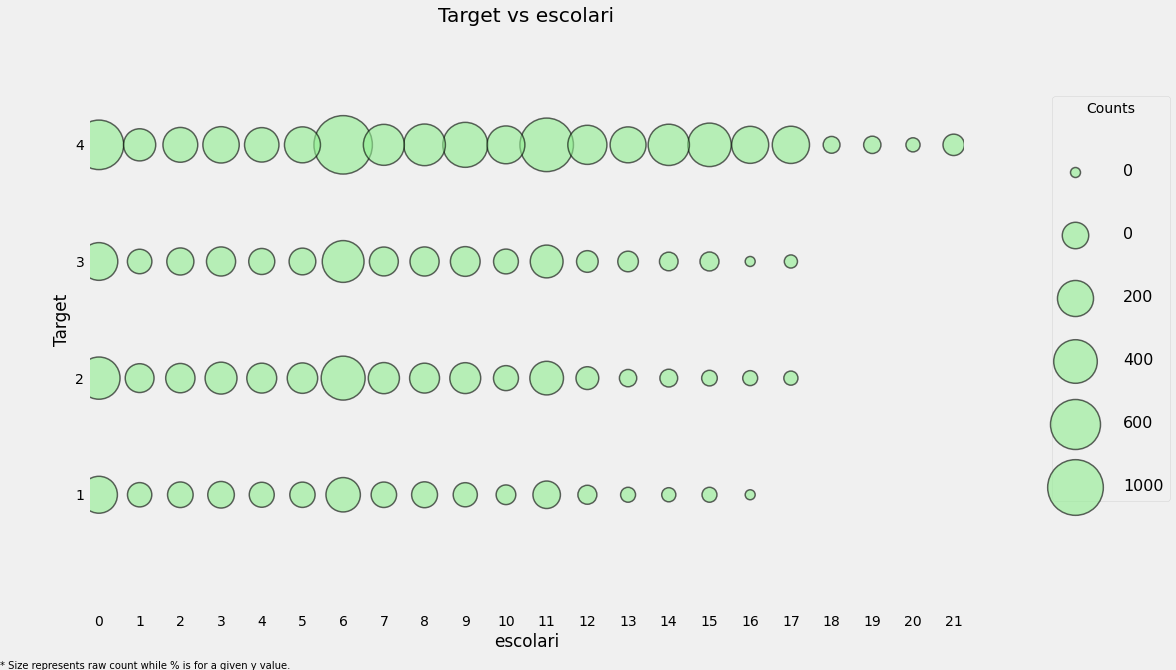

In [44]:
plot_categoricals('escolari', 'Target', data, annotate = False)

각 열의 나머지 결측값은 귀책으로 알려진 공정으로 채워집니다. 일반적으로 사용되는 몇 가지 귀책 유형이 있으며 가장 간단하고 효과적인 방법 중 하나는 결측값을 열의 중위수로 채우는 것입니다.


결측값의 마지막 단계로, 두 값 중 하나가 결측된 경우의 목표값 분포를 표시할 수 있습니다.


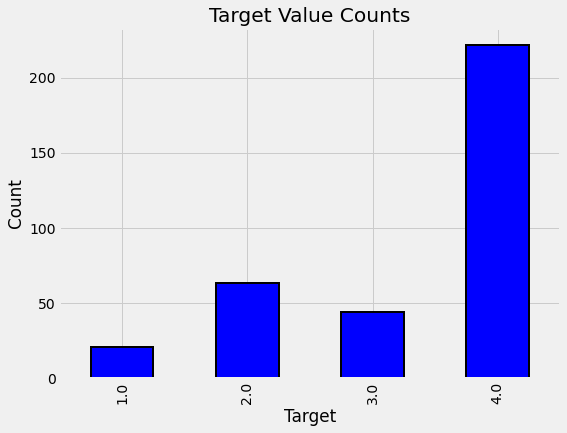

In [45]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 'Target')

이 분포는 일반적으로 모든 데이터에 대해 일치하는 것으로 보입니다.


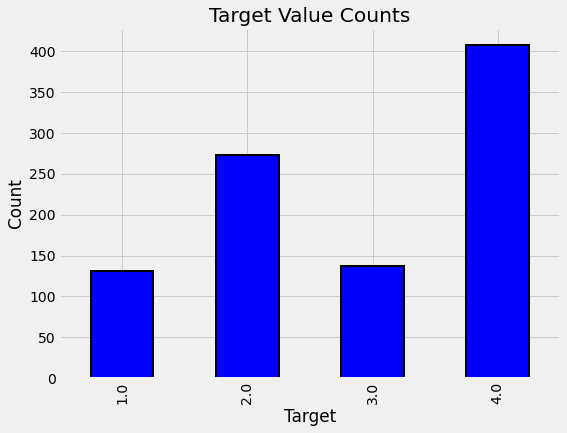

In [46]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 'Target')

이것은 2의 높은 유병률을 고려할 때 더 많은 빈곤의 지표가 될 수 있는 것처럼 보입니다: 중간 정도의 빈곤.

이것은 중요한 점을 나타냅니다. 때로는 누락된 정보도 제공된 정보만큼 중요합니다.


# Feature Engineering


In [47]:
id_ = ['Id', 'idhogar', 'Target']

In [48]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [49]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [50]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [51]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

# 리스트를 합쳤을때 동일한 변수가 있는지 확인
print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

There are no repeats:  True
We covered every variable:  True


In [52]:
Counter(x).values()

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [53]:
type(Counter(x).values())

dict_values

In [54]:
np.array(list(Counter(x).values())) == 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Squared Variables


먼저, 가장 쉬운 단계는 모든 제곱 변수를 제거하는 것입니다. 선형 모델이 비선형 관계를 학습하는 데 도움이 될 수 있기 때문에 피쳐 엔지니어링의 일부로 변수가 제곱되거나 변환되는 경우가 있습니다. 그러나 더 복잡한 모델을 사용할 것이기 때문에 이러한 사각 기능은 중복됩니다. 그것들은 정사각형 버전이 아닌 버전과 높은 상관관계가 있으므로 관련 정보를 추가하고 교육을 느리게 하여 실제로 우리 모델을 해칠 수 있습니다.

For an example, let's take a look at SQBage vs age.



C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


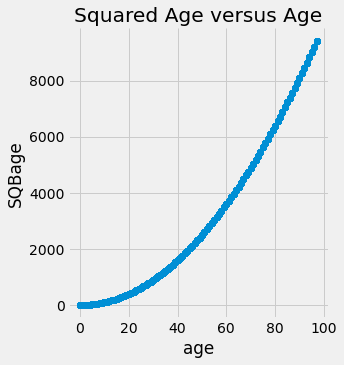

In [55]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

이 변수들은 높은 상관관계가 있으므로 두 변수 모두를 데이터에 보관할 필요가 없습니다.


In [56]:
# Remove squared variables
data = data.drop(columns = sqr_)
data.shape

(33413, 136)

### Id Variables

식별을 위해 필요하므로 데이터에 있는 그대로 유지됩니다.

### Household Level Variables

먼저 가장으로 부분 집합한 다음 가구 수준 변수로 부분 집합을 취하겠습니다.



In [57]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

대부분의 가구 수준 변수의 경우 이러한 변수를 그대로 유지할 수 있습니다. 각 가구에 대한 예측을 수행하고자 하므로 이러한 변수를 특징으로 사용합니다. 그러나 일부 중복 변수를 제거하고 기존 데이터에서 파생된 기능을 추가할 수도 있습니다.


### Redundant Household Variables
가구 변수들 간의 상관관계를 살펴봅시다. 상관 관계가 너무 높은 변수가 있으면 상관 관계가 높은 변수 쌍 중 하나를 제거할 수 있습니다.

다음 코드는 절대 크기 상관 관계가 0.95보다 큰 변수를 식별합니다.


In [58]:
corr_matrix = heads.corr()

In [59]:
np.triu(np.ones(corr_matrix.shape), k=1)

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)

C:\Users\HOME\AppData\Local\Temp/ipykernel_11492/3676972537.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)


array([[False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

In [61]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

C:\Users\HOME\AppData\Local\Temp/ipykernel_11492/2621372733.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


Target    hacdor    hacapo      v14a    refrig  paredblolad  \
Target           NaN -0.136275 -0.096313  0.068230  0.119607     0.254469   
hacdor           NaN       NaN  0.593867 -0.086701 -0.066409    -0.113787   
hacapo           NaN       NaN       NaN -0.123276 -0.075336    -0.094350   
v14a             NaN       NaN       NaN       NaN  0.145417     0.065795   
refrig           NaN       NaN       NaN       NaN       NaN     0.128958   
...              ...       ...       ...       ...       ...          ...   
hogar_adul       NaN       NaN       NaN       NaN       NaN          NaN   
hogar_mayor      NaN       NaN       NaN       NaN       NaN          NaN   
hogar_total      NaN       NaN       NaN       NaN       NaN          NaN   
bedrooms         NaN       NaN       NaN       NaN       NaN          NaN   
qmobilephone     NaN       NaN       NaN       NaN       NaN          NaN   

              paredzocalo  paredpreb  pisocemento  pareddes  paredmad  \
Target          -0.078851  -0.104545    -0.209131 -0.096893 -0.152979   
hacdor           0.026165   0.019816     0.110713  0.122610  0.068846   
hacapo           0.022254   0.007634     0.089127  0.134901  0.042265   
v14a             0.002527   0.007668    -0.020410 -0.128082 -0.068496   
refrig          -0.042125  -0.006812    -0.099088 -0.088633 -0.114895   
...                   ...        ...          ...       ...       ...   
hogar_adul            NaN        NaN          NaN       NaN       NaN   
hogar_mayor           NaN        NaN          NaN       NaN       NaN   
hogar_total           NaN        NaN          NaN       NaN       NaN   
bedrooms              NaN        NaN          NaN       NaN       NaN   
qmobilephone          NaN        NaN          NaN       NaN       NaN   

              paredzinc  paredfibras  paredother  pisomoscer  pisoother  \
Target        -0.040128    -0.039861    0.005231    0.275452   0.016832   
hacdor         0.086632    -0.007015   -0.005960   -0.143259  -0.005960   
hacapo         0.118369    -0.005219   -0.004434   -0.120922  -0.004434   
v14a          -0.034484     0.003483    0.002960    0.094633   0.002960   
refrig        -0.049882    -0.013233    0.007742    0.184785   0.007742   
...                 ...          ...         ...         ...        ...   
hogar_adul          NaN          NaN         NaN         NaN        NaN   
hogar_mayor         NaN          NaN         NaN         NaN        NaN   
hogar_total         NaN          NaN         NaN         NaN        NaN   
bedrooms            NaN          NaN         NaN         NaN        NaN   
qmobilephone        NaN          NaN         NaN         NaN        NaN   

              pisonatur  pisonotiene  pisomadera  techozinc  techoentrepiso  \
Target        -0.054463    -0.114144   -0.103487   0.014357        0.032872   
hacdor         0.026892     0.116650    0.026372  -0.036627       -0.007641   
hacapo        -0.002458     0.115475    0.023931  -0.047382       -0.007023   
v14a          -0.057915    -0.140181   -0.076321   0.047145        0.012098   
refrig        -0.019392    -0.162552   -0.105376   0.016262        0.015251   
...                 ...          ...         ...        ...             ...   
hogar_adul          NaN          NaN         NaN        NaN             NaN   
hogar_mayor         NaN          NaN         NaN        NaN             NaN   
hogar_total         NaN          NaN         NaN        NaN             NaN   
bedrooms            NaN          NaN         NaN        NaN             NaN   
qmobilephone        NaN          NaN         NaN        NaN             NaN   

              techocane  techootro  cielorazo  abastaguadentro  \
Target        -0.026240   0.031516   0.295249         0.062961   
hacdor        -0.008595  -0.006613  -0.148678        -0.036094   
hacapo        -0.006394  -0.004920  -0.131246        -0.038001   
v14a           0.004268   0.003284   0.087430         0.169428   
refrig         0.002038   0.0085

In [62]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

C:\Users\HOME\AppData\Local\Temp/ipykernel_11492/2672702943.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

각 상관 변수 쌍 중 하나를 보여 줍니다. 다른 쌍을 찾으려면 corr_matrix의 부분 집합을 취하면 됩니다.

In [63]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3         1.000000  0.998287  0.910457  0.998287     0.998287
tamhog       0.998287  1.000000  0.909155  1.000000     1.000000
tamviv       0.910457  0.909155  1.000000  0.909155     0.909155
hhsize       0.998287  1.000000  0.909155  1.000000     1.000000
hogar_total  0.998287  1.000000  0.909155  1.000000     1.000000

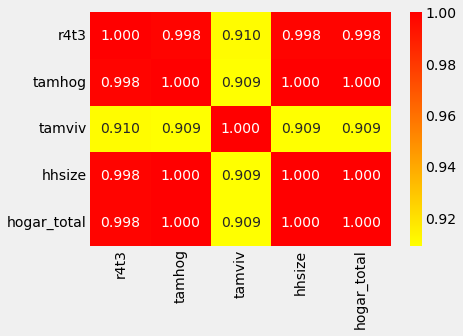

In [64]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

집의 크기와 관련된 몇 가지 변수가 있습니다.

- r4t3, 가구원 총계입니다.
- Tamhog, 가구의 크기입니다.
- tamviv, 가구원 수
- hhsize, 가구 크기입니다.
- hogar_total, 가구 내 총 개인 수입니다.

이 변수들은 모두 서로 높은 상관관계를 가지고 있습니다.</br> 
사실 hhsize는 tamhog 및 hogar_total과 완벽한 상관관계를 가지고 있습니다.</br>
정보가 중복되기 때문에 우리는 이 두 변수를 제거할 것입니다. </br>
또한 r4t3은 hhsize와 거의 완벽한 상관관계가 있기 때문에 제거할 수 있습니다.

tamviv는 가정에 살지 않는 가족 구성원이 있을 수 있기 때문에 반드시 hhsize와 같은 것은 아니다. 이 차이를 산점도에서 시각화해 보겠습니다.

In [65]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\HOME\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


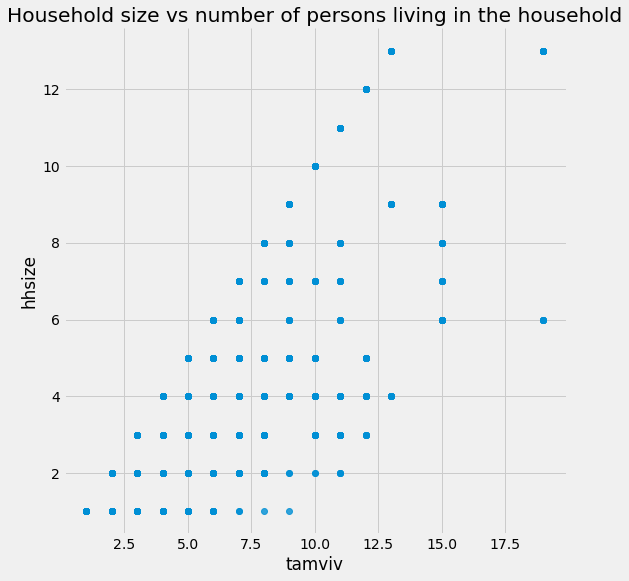

In [66]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

많은 경우에서 볼 때, 가족보다 더 많은 사람들이 살고 있습니다. 이것은 새로운 특징, 즉 이 두 측정값의 차이에 대한 좋은 아이디어를 제공합니다!

Let's make this new feature.




C:\Users\HOME\AppData\Local\Temp/ipykernel_11492/4119447328.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy = (row[x] - (1 / counts[x].nunique()),


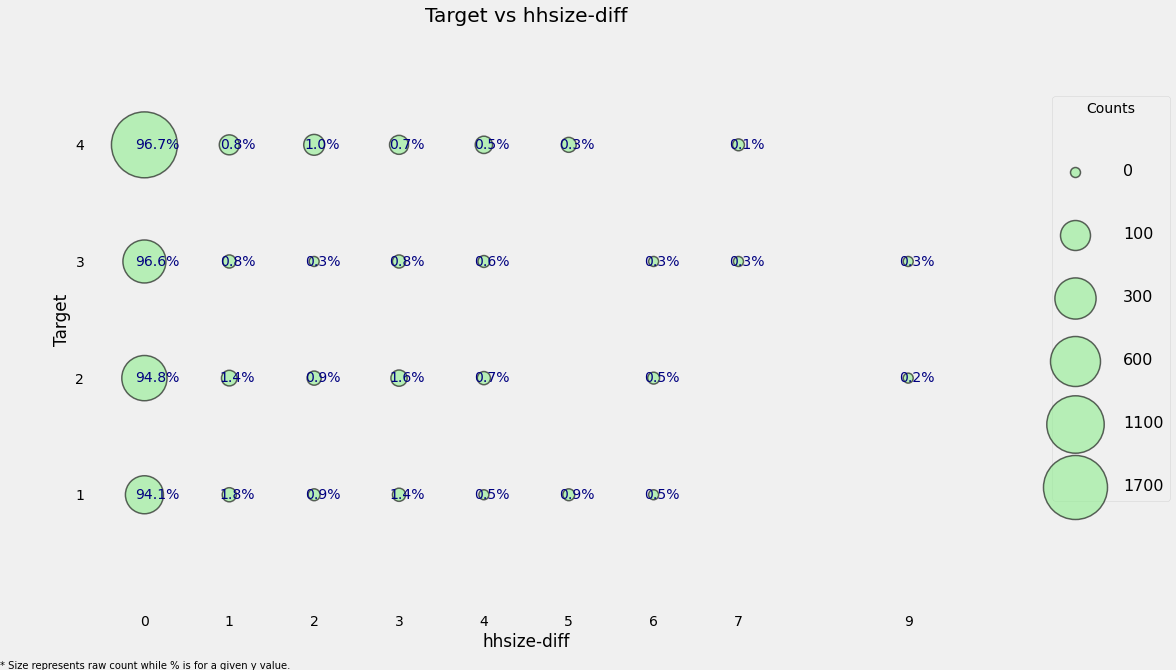

In [67]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

대부분의 가구는 차이가 없지만, 가구원보다 더 많은 사람이 살고 있는 가구가 몇 명 있습니다.

다른 중복 변수로 넘어가겠습니다. 먼저 우리는 쿠플을 볼 수 있습니다.

In [68]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

public   coopele
public   1.000000 -0.967759
coopele -0.967759  1.000000

이 변수들은 가정의 전기가 어디에서 오는지 나타냅니다. 네 가지 옵션이 있는데, 이 두 가지 옵션 중 하나가 없는 가정은 전기가 들어오지 않거나(0) 개인 공장(3)에서 얻습니다.

순서형 변수를 작성하는 중입니다.
순서형 변수를 만들어서 이 네 변수를 하나로 압축해 보겠습니다. 데이터 구분에 따라 직접 매핑을 선택할 것입니다.

- 0: 전기가 들어오지 않습니다.
- 1: 협동조합에서 전기를 공급받습니다.
- 2: CNFL, ICA, ESPH/JASEC에서 전기를 공급받습니다.
- 3: 개인 발전소에서 전기를 공급받습니다.

정렬된 변수는 고유의 순서를 가지고 있으며, 이를 위해 도메인 지식을 기반으로 우리 자신의 순서를 선택합니다. 우리가 이 새로운 오더 변수를 만든 후에 나머지 4개를 삭제할 수 있습니다. 여기에 변수가 없는 가구가 여러 개 있으므로 nan(귀속 시 채워질 것)을 사용하고 이 변수에 대한 측도가 없음을 나타내는 부울 열을 추가합니다.


In [69]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

In [70]:
for i, row in heads.iterrows():
    print(row)

Id              ID_279628684
idhogar            21eb7fcc1
Target                   4.0
hacdor                     0
hacapo                     0
                    ...     
bedrooms                   1
qmobilephone               1
hhsize-diff                0
elec                     2.0
elec-missing           False
Name: 0, Length: 99, dtype: object
Id              ID_f29eb3ddd
idhogar            0e5d7a658
Target                   4.0
hacdor                     0
hacapo                     0
                    ...     
bedrooms                   1
qmobilephone               1
hhsize-diff                0
elec                     2.0
elec-missing           False
Name: 1, Length: 99, dtype: object
Id              ID_68de51c94
idhogar            2c7317ea8
Target                   4.0
hacdor                     0
hacapo                     0
                    ...     
bedrooms                   2
qmobilephone               0
hhsize-diff                0
elec                     2.0
el

C:\Users\HOME\AppData\Local\Temp/ipykernel_11492/4119447328.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy = (row[x] - (1 / counts[x].nunique()),


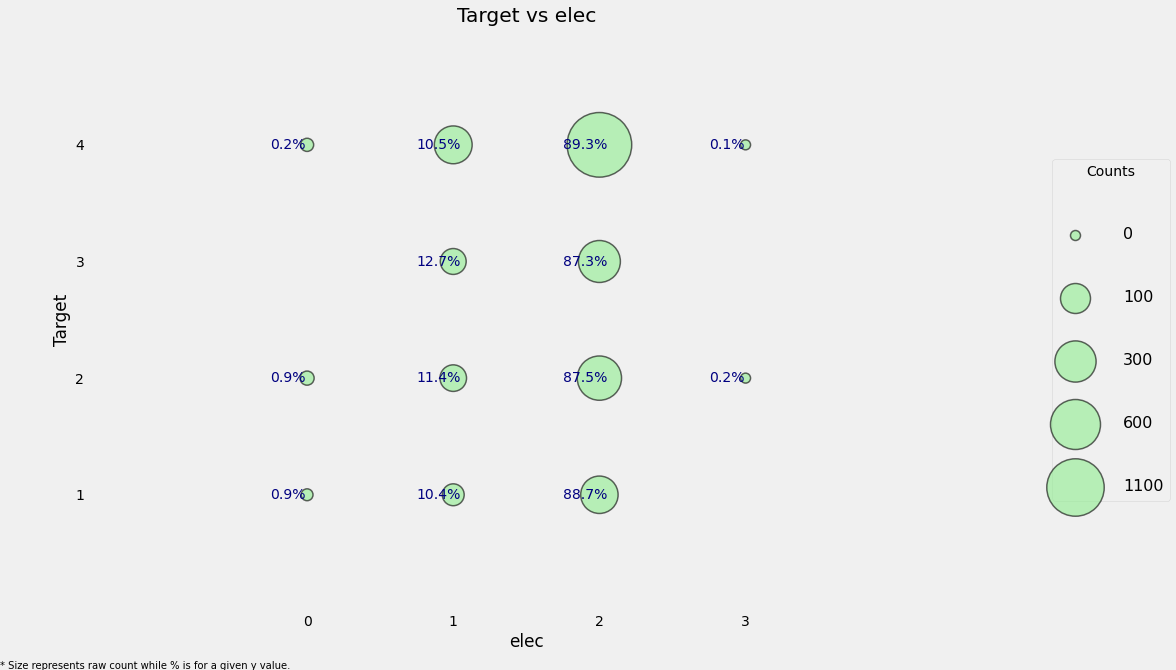

In [71]:
plot_categoricals('elec', 'Target', heads)

타깃의 모든 값에 대해 가장 일반적인 전력 공급원은 나열된 공급자 중 한 곳임을 알 수 있습니다.

마지막 중복 열은 area2입니다. </br>
이것은 그 집이 시골 지역에 있다는 것을 의미하지만, 그 집이 도시 지역에 있는지를 나타내는 변수가 있기 때문에 중복됩니다. </br>
따라서 우리는 이 칼럼을 삭제할 수 있습니다.


In [72]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

도시지역 가구(값 1)가 농촌 가구(값 0)보다 빈곤 수준이 낮을 가능성이 높은 것으로 나타났습니다.

## Creating Ordinal Variables

- "epared1"," =1 if walls are bad"
- "epared2"," =1 if walls are regular"
- "epared3"," =1 if walls are good"</br>


- "etecho1"," =1 if roof are bad"
- "etecho2"," =1 if roof are regular"
- "etecho3"," =1 if roof are good"</br>


- "eviv1"," =1 if floor are bad"
- "eviv2"," =1 if floor are regular"
- "eviv3"," =1 if floor are good"

이를 위해, 우리는 np.argmax를 사용하여 각 가구에 대해 0이 아닌 열을 찾을 수 있습니다.

순서형 변수를 만들고 나면 원래 변수를 삭제할 수 있습니다.


C:\Users\HOME\AppData\Local\Temp/ipykernel_11492/4119447328.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy = (row[x] - (1 / counts[x].nunique()),


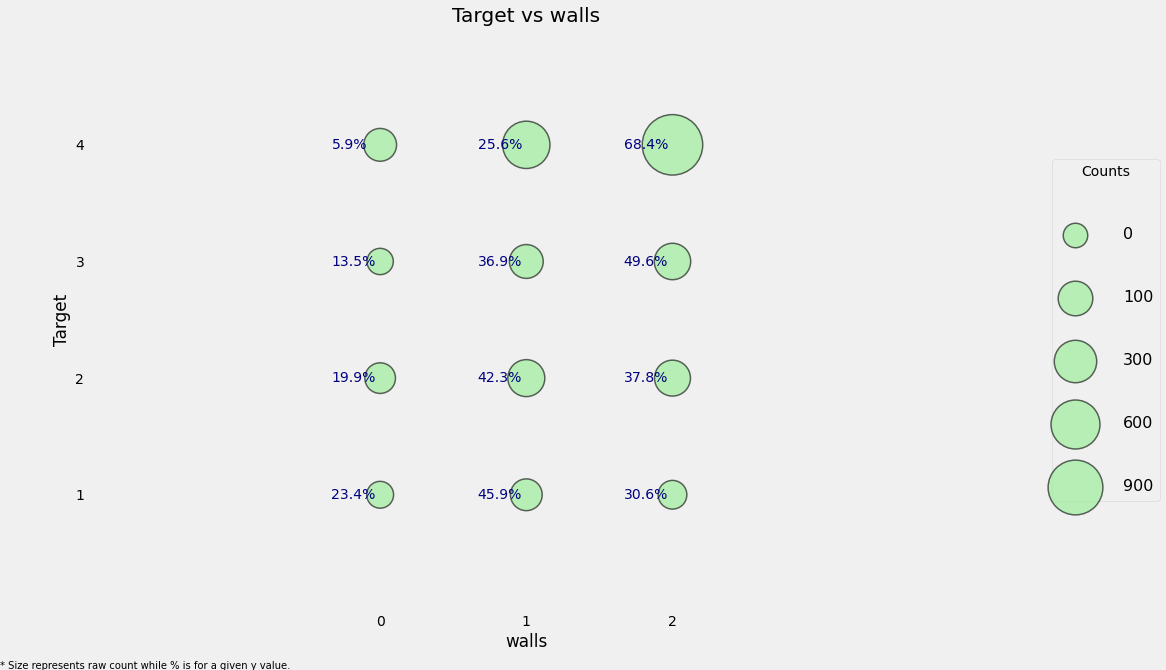

In [73]:
# np.argmax : 최소값,최대값 인덱스 위치
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])
plot_categoricals('walls', 'Target', heads)

In [74]:
heads[['epared1', 'epared2', 'epared3']]

epared1  epared2  epared3
0            0        1        0
1            0        1        0
2            0        1        0
5            0        0        1
8            1        0        0
...        ...      ...      ...
33393        0        1        0
33398        1        0        0
33400        0        1        0
33404        1        0        0
33409        0        0        1

[10307 rows x 3 columns]

In [75]:
np.array(heads[['epared1', 'epared2', 'epared3']])

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=int64)

In [76]:
np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]), axis = 1) # np.argmax : 최소값,최대값 인덱스 위치

array([1, 1, 1, ..., 1, 0, 2], dtype=int64)

In [77]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

In [78]:
heads['roof']

0        0
1        1
2        2
5        2
8        0
        ..
33393    0
33398    0
33400    1
33404    0
33409    2
Name: roof, Length: 10307, dtype: int64

# Feature Construction

변수를 순서형 피쳐에 매핑하는 것 외에도, 피쳐 구성이라고 하는 기존 데이터에서 완전히 새로운 피쳐를 작성할 수도 있습니다. 

예를 들어, 우리는 방금 만든 이전의 세 가지 특징을 더해서 그 집의 구조의 질을 전반적으로 측정할 수 있습니다.


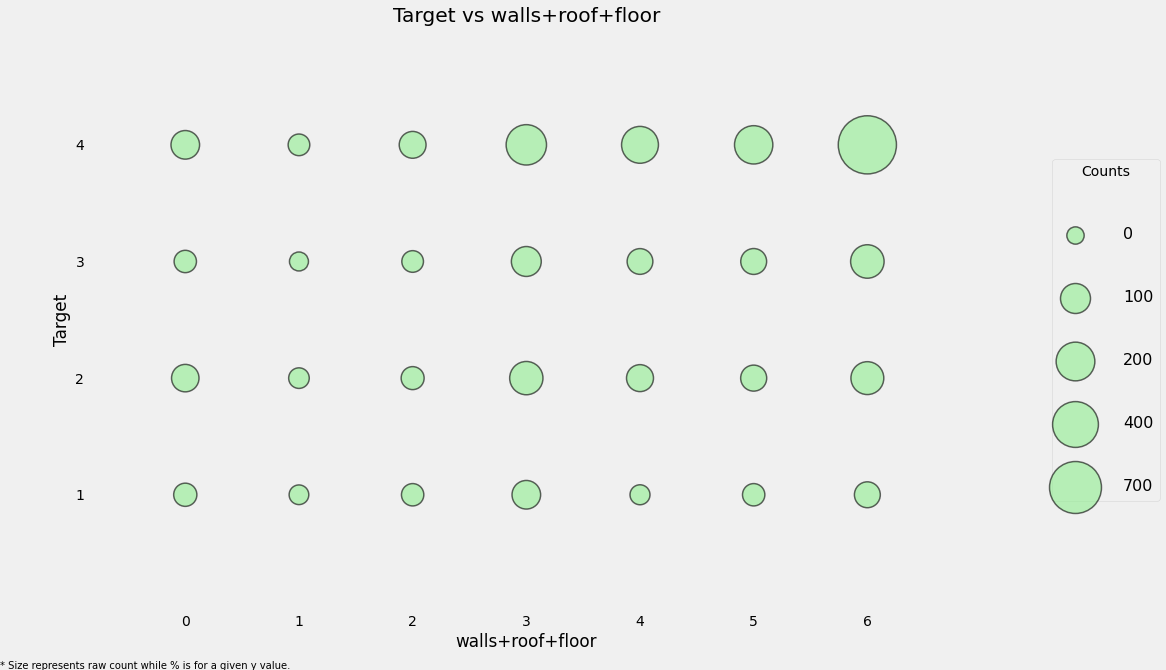

In [79]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

이 새로운 기능은 목표값 4(최저 빈곤 수준)가 '집 품질' 변수의 값이 더 높은 경향이 있기 때문에 유용할 수 있습니다. 

우리는 또한 세부적인 세부 사항을 알기 위해 이것을 표에서 볼 수 있습니다.

In [80]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head()

walls+roof+floor  Target  Normalized Count
0                 0     4.0          0.376404
1                 0     2.0          0.320225
2                 0     1.0          0.162921
3                 0     3.0          0.140449
4                 1     4.0          0.323529

다음 변수는 집의 질에 대한 경고일 것입니다. 화장실, 전기, 바닥, 수도, 천장이 없는 경우 각각 -1점으로 마이너스 값이 됩니다.


In [81]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

In [82]:
heads['warning']

0        0
1        0
2        0
5        0
8        0
        ..
33393    2
33398    1
33400    1
33404    1
33409    1
Name: warning, Length: 10307, dtype: int64

이러한 관계를 시각화하기 위해 flot_categicals 함수를 계속 사용할 수 있지만 Seaborn에는 범주형에서 사용할 수 있는 여러 가지 플롯 옵션도 있습니다. 하나는 Y축에 변수의 분포를 보여주는 바이올린 플롯이고 각 플롯의 너비는 해당 범주의 관측치 수를 나타냅니다.


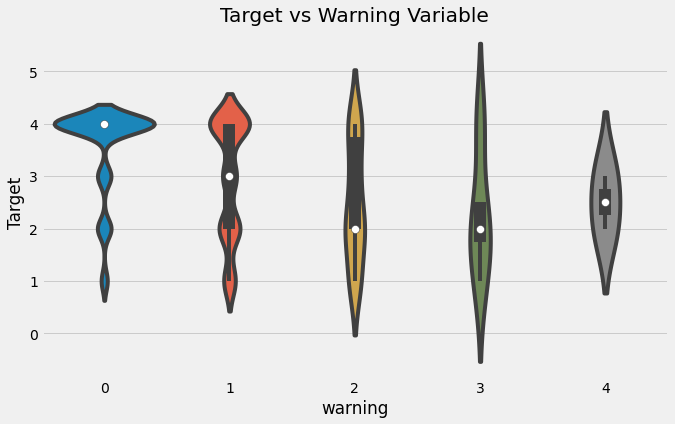

In [83]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'warning', y = 'Target', data = heads);
plt.title('Target vs Warning Variable');

C:\Users\HOME\AppData\Local\Temp/ipykernel_11492/4119447328.py:30: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy = (row[x] - (1 / counts[x].nunique()),


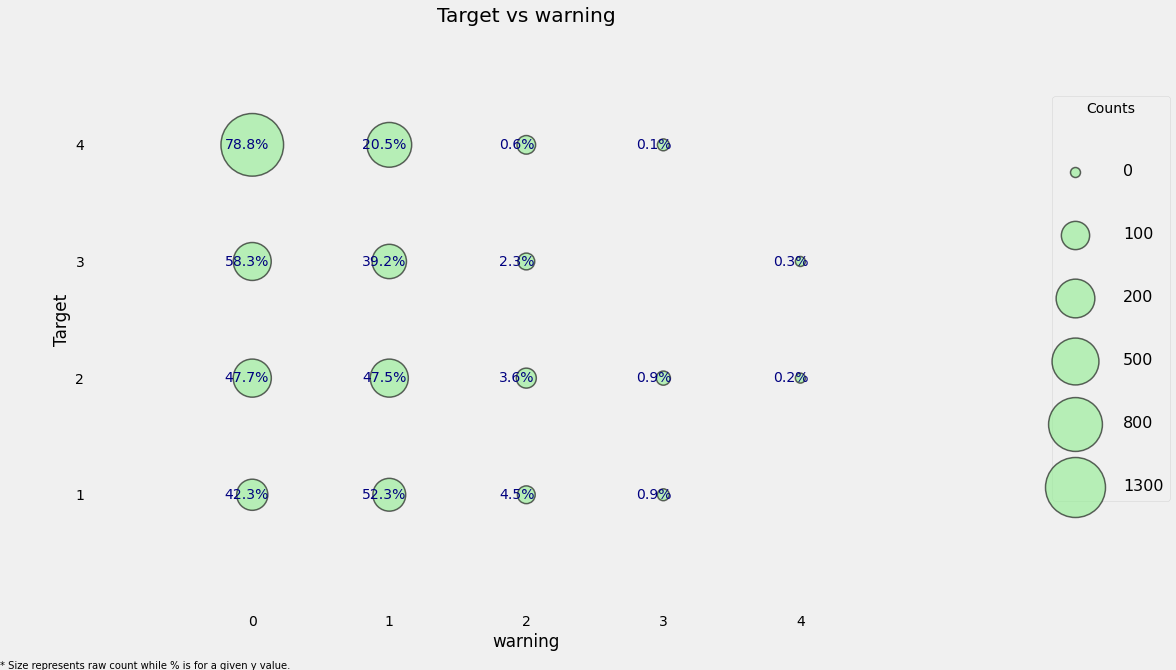

In [84]:
plot_categoricals('warning', 'Target', data = heads)

바이올린 플롯은 target이 실제보다 더 작고 더 큰 값을 가질 수 있는 것처럼 보이면서 범주형 변수를 부드럽게 하기 때문에 좋지 않습니다. 

그럼에도 불구하고, 우리는 경고 표지판이 없고 빈곤층이 가장 낮은 높은 집중도를 볼 수 있습니다. 

이것이 유용한 기능인 것처럼 보이지만, 모델링을 시작하기 전까지는 확실히 알 수 없습니다!



우리가 현재 만들 수 있는 마지막 household feature는 냉장고, 컴퓨터, 태블릿 또는 텔레비전을 갖는 것에 대한 점수를 받는 보너스입니다.

C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


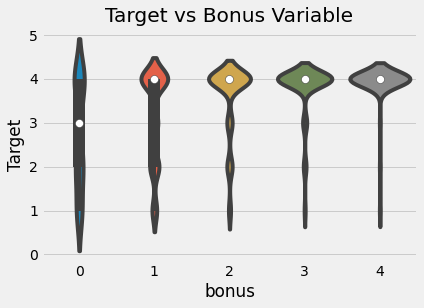

In [85]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + heads['computer'] + (heads['v18q1'] > 0) + heads['television'])

sns.violinplot('bonus', 'Target', data = heads, figsize = (10, 6));
plt.title('Target vs Bonus Variable');

In [86]:
heads['refrig'] + heads['computer'] + (heads['v18q1'] > 0) + heads['television']

0        1
1        2
2        1
5        2
8        1
        ..
33393    0
33398    1
33400    1
33404    1
33409    1
Length: 10307, dtype: int64

## Per Capita Features

추가적인 특징으로는 각 가구에 대한 특정 측정치의 수를 계산할 수 있습니다.



In [87]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Exploring Household Variables

우리의 특징들을 정리하기 위해 많은 수고를 들인 후, 우리는 이제 타겟과 관련하여 그것들을 살펴볼 수 있습니다. 우리는 이미 이것을 조금 했지만, 이제 우리는 관계를 계량화하려고 노력할 수 있습니다.

### Measuring Relationships
두 변수 사이의 관계를 측정하는 방법은 여러 가지가 있습니다. 여기서는 다음 두 가지를 살펴보겠습니다.

- Pearson 상관 관계: -1부터 1까지 두 변수 사이의 선형 관계를 측정합니다.
- Spearman 상관 관계: -1부터 1까지 두 변수 사이의 단조 관계를 측정합니다.

Spearman 상관 관계는 관계가 선형이 아니더라도 한 변수가 증가하면 다른 변수도 증가하면 1입니다.

반면에 Pearson 상관 계수는 증가가 정확히 선형인 경우에만 1이 될 수 있습니다. 이것들은 예를 통해 가장 잘 설명됩니다.

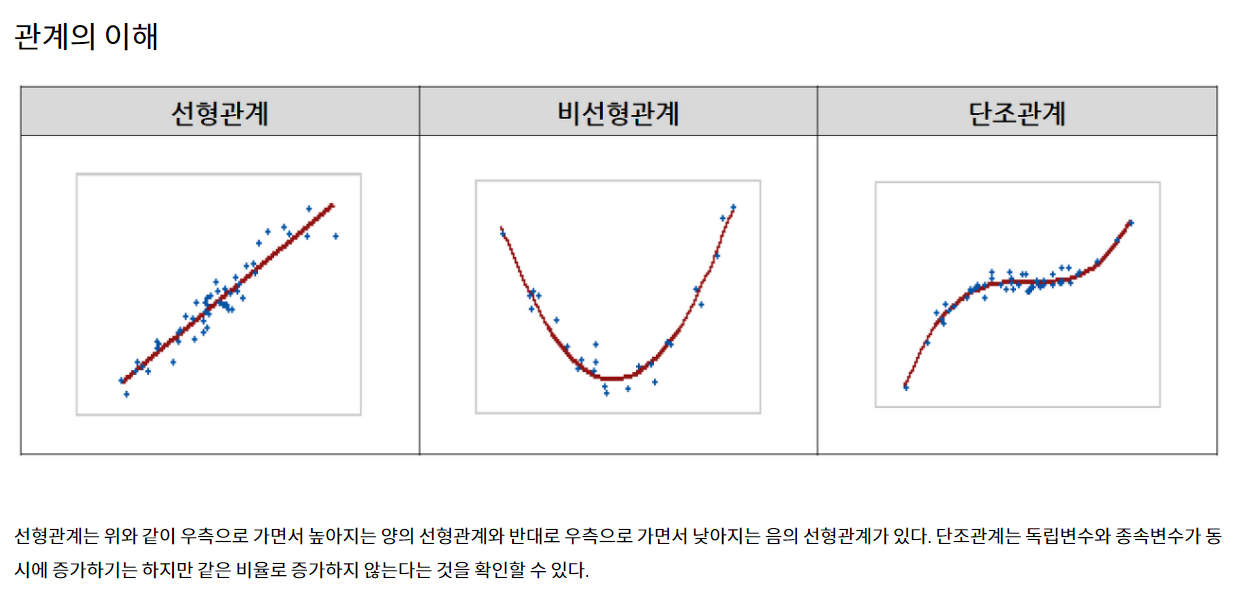

In [88]:
from scipy.stats import spearmanr

In [89]:
def plot_corrs(x, y):
    """Plot data and show the spearman and pearson correlation."""
    
    # Calculate correlations
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x, y)[0, 1]
    
    # Scatter plot
    data = pd.DataFrame({'x': x, 'y': y})
    plt.figure( figsize = (6, 4))
    sns.regplot('x', 'y', data = data, fit_reg = False);
    plt.title(f'Spearman: {round(spr, 2)}; Pearson: {round(pcr, 2)}');

In [90]:
range(10)

range(0, 10)

C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


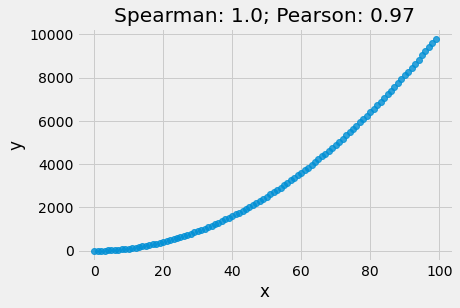

In [91]:
x = np.array(range(100))
y = x ** 2

plot_corrs(x, y)

In [92]:
# Use only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908

Most positively correlated variables:
               feature     pcorr
97   phones-per-capita  0.299026
98               floor  0.307605
99    walls+roof+floor  0.332446
100           meaneduc  0.333652
101             Target  1.000000


음의 상관 관계에 대해서는 변수를 늘리면 목표값이 감소하여 빈곤 심각도가 증가함을 나타냅니다. 따라서, 경고가 증가할수록 빈곤 수준도 증가하는데, 이것은 집에 대한 잠재적인 나쁜 징후를 보여주기 위한 것이었기 때문에 이치에 맞습니다. 

hogar_nin은 가족 내에서 0-19명의 아이들의 수를 의미하는데, 이것은 또한 타당합니다: 어린 아이들은 더 높은 수준의 빈곤으로 이어지는 가족의 재정적 스트레스 원천이 될 수 있습니다.</br>
또는 사회경제적 지위가 낮은 가정은 그들 중 한 명이 성공할 수 있다는 희망으로 더 많은 아이를 낳습니다.</br>
설명이 무엇이든 간에, 가족의 규모와 빈곤 사이에는 진정한 연관성이 있습니다.

반면에 양수 상관의 경우 목표값이 높을수록 빈곤 심각도가 감소함을 나타냅니다. </br>
가장 상관관계가 높은 가구 수준 변수는 가구 내 성인의 평균 교육 수준인 평균 교육입니다. </br>

교육과 빈곤 사이의 이러한 관계는 직관적으로 타당합니다: 더 높은 수준의 교육은 일반적으로 더 낮은 수준의 빈곤과 관련이 있습니다. 우리는 어떤 것이 어떤 원인인지 반드시 알 수는 없지만, 이것들이 같은 방향으로 움직이는 경향이 있다는 것은 알고 있습니다.

상관 관계 값에 대한 일반적인 지침은 다음과 같으나, 사용자에게 요청하는 사용자(이러한 값의 출처)에 따라 달라집니다.

- .00-.19 "매우 약합니다."
- .20-.39 "약합니다"
- .40-.59 "비공개"입니다.
- .60-.79 "강력합니다"
- .80-1.0 "매우 강력합니다."

이러한 상관 관계는 우리 모델이 기능에서 대상으로의 매핑을 학습하는 데 사용할 수 있는 몇 가지 약한 관계가 있다는 것을 보여줍니다.

이제 스피어맨 상관관계로 넘어갈 수 있습니다.

In [93]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)

scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

Spearman 상관 계수 계산에는 관계의 유의 수준을 나타내는 p 값도 함께 제공됩니다. p-값이 0.05보다 작으면 일반적으로 유의한 것으로 간주되지만 다중 비교를 수행하므로 P-값을 Bonferroni 보정이라고 하는 공정인 비교 수로 나누려고 합니다.


In [94]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
       feature     scorr        pvalue
97     warning -0.307326  4.682829e-66
68  dependency -0.281516  2.792620e-55
85   hogar_nin -0.236225  5.567218e-39
80        r4t1 -0.219226  1.112230e-33
49       eviv1 -0.217803  2.952571e-33

Most positive Spearman correlations:
              feature     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
95              floor  0.309638  4.466091e-67
99  phones-per-capita  0.337377  4.760104e-80
96   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


대부분의 경우 두 가지 상관 계산 방법이 일치합니다. 호기심으로, 우리는 가장 멀리 떨어져 있는 가치를 찾을 수 있습니다.


In [95]:
# 피어슨 - 스피어만
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

feature     pcorr     scorr        pvalue      diff
77    rooms-per-capita  0.152185  0.223303  6.521453e-35 -0.071119
85               v18q1  0.197493  0.244200  1.282664e-41 -0.046708
87  tablets-per-capita  0.204638  0.248642  3.951568e-43 -0.044004
2                 r4t1 -0.260917 -0.219226  1.112230e-33 -0.041691
97   phones-per-capita  0.299026  0.337377  4.760104e-80 -0.038351

In [96]:
corrs.sort_values('diff').dropna().tail()

feature     pcorr     scorr        pvalue      diff
57    techozinc  0.014357  0.003404  8.528369e-01  0.010954
49  hogar_mayor -0.025173 -0.041722  2.290994e-02  0.016549
88       edjefe  0.235687  0.214736  2.367521e-32  0.020951
66       edjefa  0.052310  0.005114  7.804715e-01  0.047197
17   dependency -0.126465 -0.281516  2.792620e-55  0.155051

상관 관계에서 가장 큰 불일치는 의존성입니다. 목표값 대 종속성의 산점도를 만들어 관계를 시각화할 수 있습니다. 두 변수 모두 이산형 변수이므로 그림에 지터를 조금 추가합니다.


C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


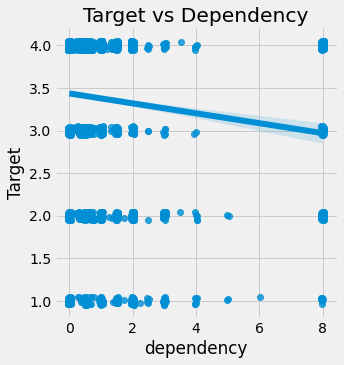

In [97]:
sns.lmplot('dependency', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Dependency');

관계를 보기는 어렵지만 약간 부정적입니다: 의존도가 높아질수록 대상의 가치는 감소합니다. 이것은 타당합니다: 의존성은 의존적인 개인의 수를 비의존적인 개인의 수로 나눈 것입니다. 우리가 이 가치를 늘리면 빈곤의 심각성은 증가하는 경향이 있습니다: 더 많은 의존적인 가족 구성원을 갖는 것은 비의존적인 가족 구성원의 지원을 받아야 하기 때문에 더 높은 수준의 빈곤으로 이어집니다.

C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


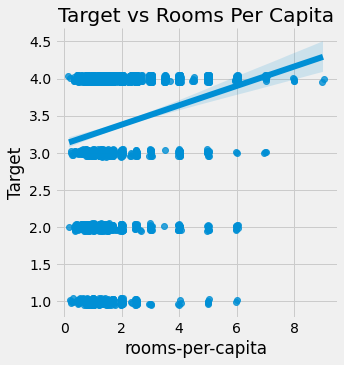

In [98]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms Per Capita');

### Correlation Heatmap


내가 가장 좋아하는 플롯 중 하나는 하나의 이미지에 수많은 정보를 보여주기 때문에 상관 히트맵입니다. 히트맵의 경우 7개의 변수를 선택하고 자체 및 대상 간의 상관 관계를 표시합니다.


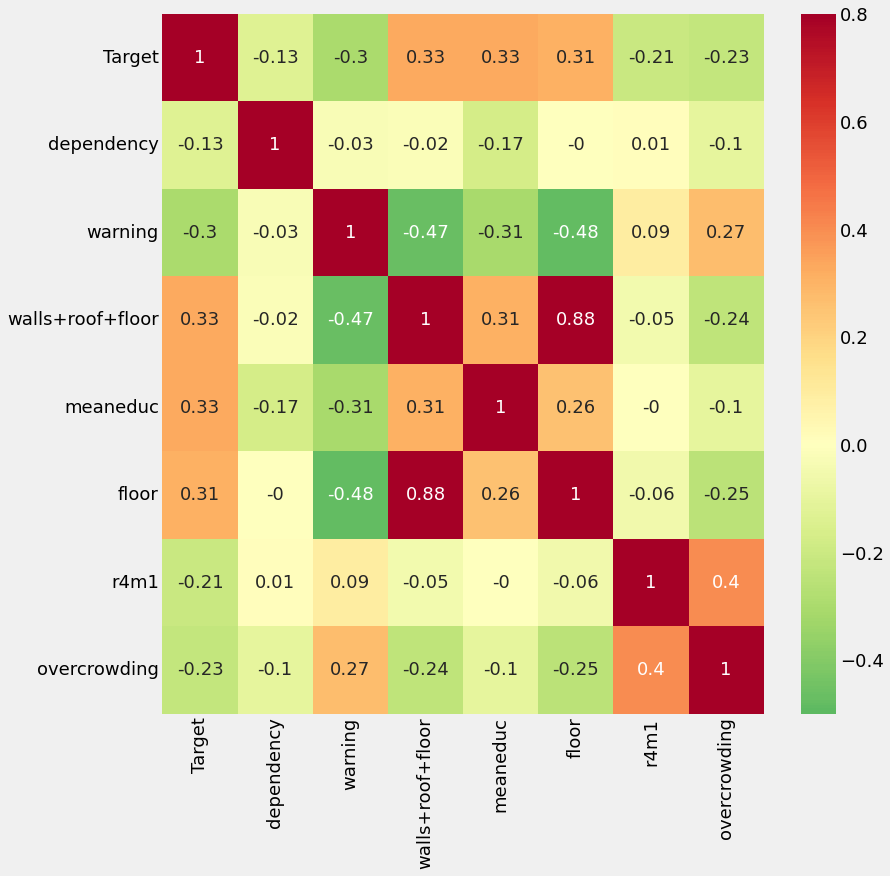

In [99]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

# Calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

이 도표는 Target과 약한 상관관계를 갖는 많은 변수가 있음을 보여줍니다. 또한 공선성으로 인해 문제가 될 수 있는 일부 변수(예: 바닥 및 벽+지붕+바닥) 간에 높은 상관관계가 있습니다.

## Features Plot

가구 수준 데이터의 최종 탐색을 위해 대상과 가장 상관관계가 높은 일부 변수의 도표를 만들 수 있습니다. 이것은 위쪽 삼각형에 산점도, 대각선에 커널 밀도 추정(kde) 플롯, 아래쪽 삼각형에 2D KDE 플롯을 보여줍니다.


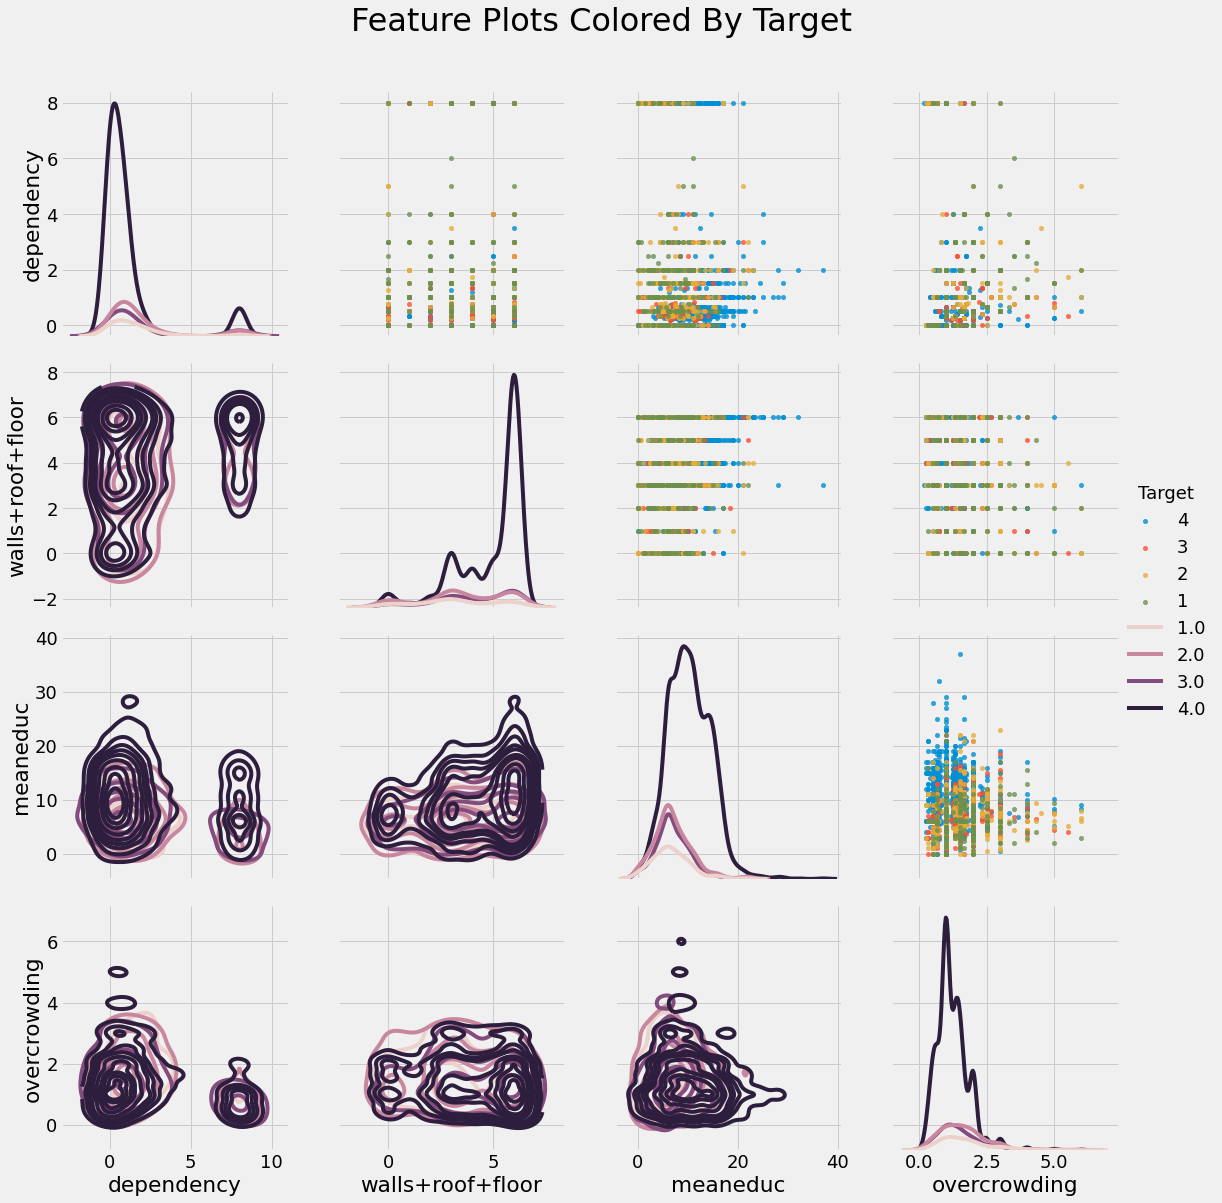

In [100]:
import warnings
warnings.filterwarnings('ignore')

# Copy the data for plotting
plot_data = train_heads[['Target', 'dependency', 'walls+roof+floor',
                         'meaneduc', 'overcrowding']]

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 4, diag_sharey=False,
                    hue = 'Target', hue_order = [4, 3, 2, 1], 
                    vars = [x for x in list(plot_data.columns) if x != 'Target'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.8, s = 20)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target', size = 32, y = 1.05);

지금은 가정 변수의 기능 공학을 그대로 두겠습니다. 나중에 모델 성능이 마음에 들지 않으면 이 단계로 다시 돌아올 수 있습니다.


In [101]:
household_feats = list(heads.columns)

# Individual Level Variables

개별 수준 변수에는 부울(True 또는 False의 경우 1 또는 0)과 순서(의미 있는 순서가 있는 이산 값)의 두 가지 유형이 있습니다.


In [102]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

# Redundant Individual Variables

중복되는 개별 변수를 식별하기 위해 가구 수준 변수로 수행한 것과 동일한 프로세스를 수행할 수 있습니다. 상관 계수의 절대 크기가 0.95보다 큰 모든 변수에 초점을 맞춥니다.



In [103]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

In [104]:
ind = ind.drop(columns = 'male')

## Creating Ordinal Variables

가계 수준 데이터와 마찬가지로 기존 열을 서수 변수에 매핑할 수 있습니다. 여기서 우리는 instlevel1: 교육 수준 없음에서 instlevel9: 대학원 교육까지 개인의 교육 정도를 나타내는 instlevel_ 변수에 초점을 맞출 것입니다.

서수 변수를 생성하기 위해 각 개인에 대해 0이 아닌 열을 찾기만 하면 됩니다. 교육에는 고유한 순서가 있으므로(높을수록 좋음) 이러한 순서 변수로의 변환은 문제 컨텍스트에서 의미가 있습니다.



In [105]:
ind[[c for c in ind if c.startswith('instl')]].head()

instlevel1  instlevel2  instlevel3  instlevel4  instlevel5  instlevel6  \
0           0           0           0           1           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           1           0   
3           0           0           0           1           0           0   
4           0           0           0           0           1           0   

   instlevel7  instlevel8  instlevel9  
0           0           0           0  
1           0           1           0  
2           0           0           0  
3           0           0           0  
4           0           0           0

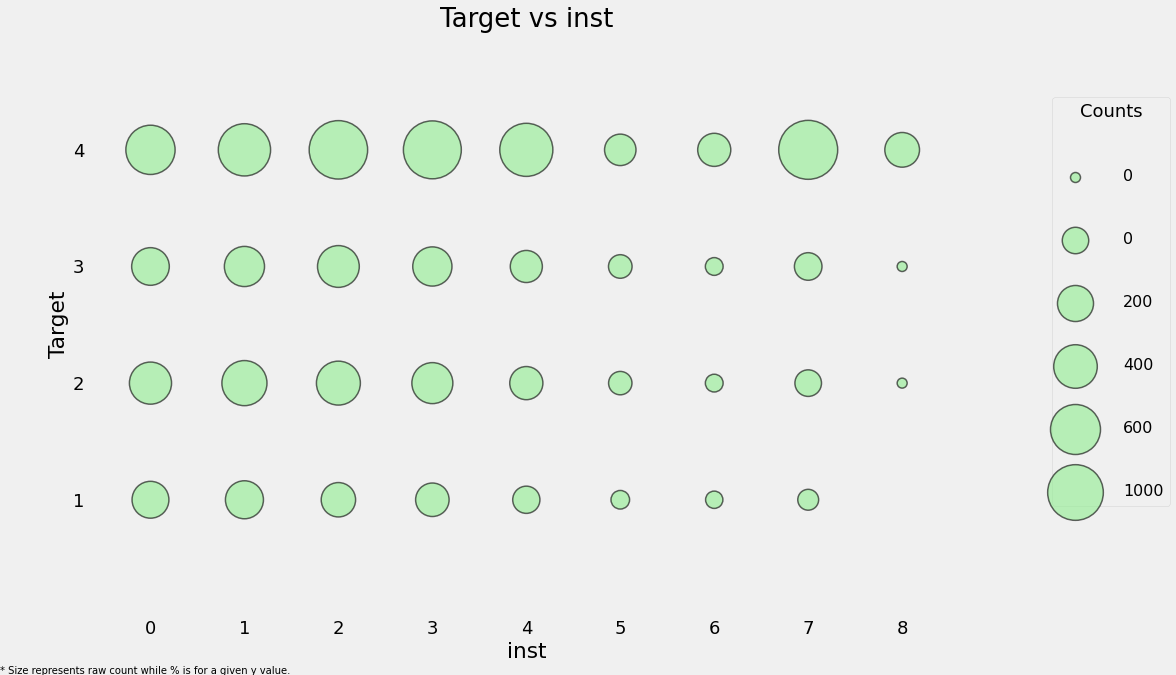

In [106]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

plot_categoricals('inst', 'Target', ind, annotate = False);

높은 수준의 교육은 덜 극단적인 빈곤 수준에 해당하는 것으로 보입니다. 우리는 이것이 개인 수준이라는 것을 명심해야 하며 결국에는 이 데이터를 가구 수준에서 집계해야 합니다.


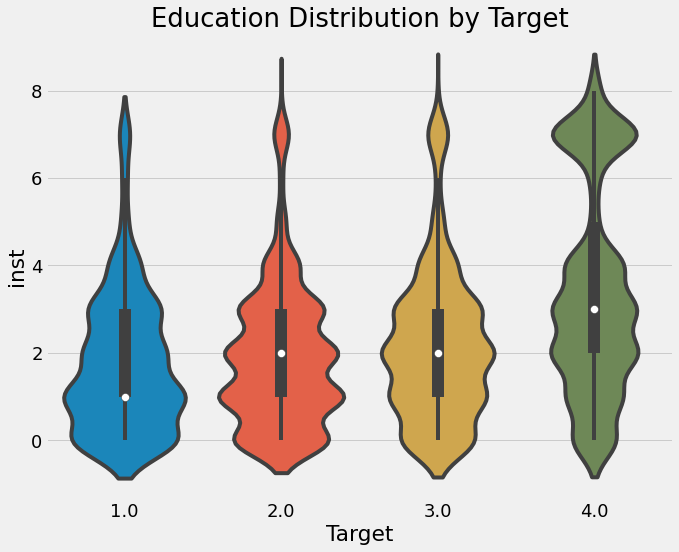

In [107]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Education Distribution by Target');

In [108]:
# Drop the education columns
# ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
ind.shape

(33413, 40)

### Feature Construction
기존 데이터를 사용하여 몇 가지 기능을 만들 수 있습니다. 예를 들어 학력을 나이로 나눌 수 있습니다.



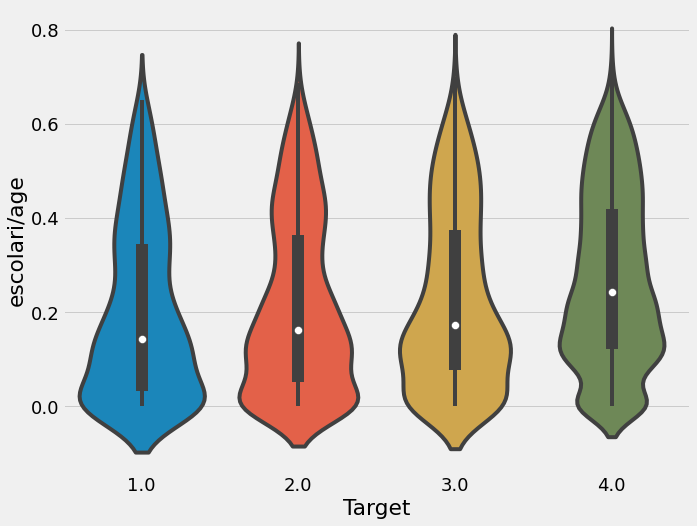

In [109]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10, 8))
sns.violinplot('Target', 'escolari/age', data = ind);

우리는 또한 우리의 새로운 변수 inst를 가지고 이것을 나이로 나눌 수 있습니다. tech라는 이름의 마지막 변수는 태블릿과 휴대전화의 조합을 나타냅니다.


In [110]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

## Feature Engineering through Aggregations

개별 데이터를 가계 데이터에 통합하기 위해서는 가구별로 집계해야 합니다. 가장 간단한 방법은 패밀리 IDHogar를 기준으로 그룹화한 다음 데이터를 Agg하는 것입니다. 순서 또는 연속형 변수의 집합에는 6개를 사용할 수 있는데, 그 중 5개는 pandas에 내장되어 있고, 1개는 우리 스스로 range를 정의합니다. 부울 집계는 동일할 수 있지만 이렇게 하면 중복 열이 많이 생성되어 삭제해야 합니다. 이 경우에는 동일한 집계를 사용한 다음 다시 돌아가서 중복 열을 삭제하겠습니다.



In [111]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', range_])
ind_agg.head()

v18q                      dis                      female          \
           min max sum count range_ min max sum count range_    min max sum   
idhogar                                                                       
000a08204    1   1   3     3      0   0   0   0     3      0      0   1   1   
000bce7c4    0   0   0     2      0   0   1   1     2      1      0   1   1   
001845fb0    0   0   0     4      0   0   0   0     4      0      0   1   2   
001ff74ca    1   1   2     2      0   0   0   0     2      0      1   1   2   
003123ec2    0   0   0     4      0   0   0   0     4      0      0   1   1   

                       estadocivil1                      estadocivil2          \
          count range_          min max sum count range_          min max sum   
idhogar                                                                         
000a08204     3      1            0   1   1     3      1            0   1   2   
000bce7c4     2      1            0   0   0     2      0            0   0   0   
001845fb0     4      1            0   0   0     4      0            0   1   2   
001ff74ca     2      0            0   1   1     2      1            0   0   0   
003123ec2     4      1            0   1   2     4      1            0   1   2   

                       estadocivil3                      estadocivil4          \
          count range_          min max sum count range_          min max sum   
idhogar                                                                         
000a08204     3      1            0   0   0     3      0            0   0   0   
000bce7c4     2      0            1   1   2     2      0            0   0   0   
001845fb0     4      1            0   0   0     4      0            0   0   0   
001ff74ca     2      0            0   0   0     2      0            0   0   0   
003123ec2     4      1            0   0   0     4      0            0   0   0   

                       estadocivil5                      estadocivil6          \
          count range_          min max sum count range_          min max sum   
idhogar                                                                         
000a08204     3      0            0   0   0     3      0            0   0   0   
000bce7c4     2      0            0   0   0     2      0            0   0   0   
001845fb0     4      0            0   0   0     4      0            0   0   0   
001ff74ca     2      0            0   1   1     2      1            0   0   0   
003123ec2     4      0            0   0   0     4      0            0   0   0   

                       estadocivil7                      parentesco1          \
          count range_          min max sum count range_         min max sum   
idhogar                                                                        
000a08204     3      0            0   0   0     3      0           0   1   1   
000bce7c4     2      0            0   0   0     2      0           0   1   1   
001845fb0     4      0            0   1   2     4      1           0   1   1   
001ff74ca     2      0            0   0   0     2      0           0   1   1   
003123ec2     4      0            0   0   0     4      0           0   1   1   

                       parentesco2                      parentesco3          \
          count range_         min max sum count range_         min max sum   
idhogar                                                                       
000a08204     3      1           0   1   1     3      1           0   1   1   
000bce7c4     2      1           0   1   1     2      1           0   0   0   
001845fb0     4      1           0   1   1     4      1           0   1   2   
001ff74ca     2      1           0   0   0     2      0           0   1   1   
003123ec2     4      1           0   1   1     4      1           0   1   2   

                       parentesco4                      parentesco5          \
          count range_         min max sum count range_         min max sum  

In [112]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

v18q-min  v18q-max  v18q-sum  v18q-count  v18q-range_  dis-min  \
idhogar                                                                     
000a08204         1         1         3           3            0        0   
000bce7c4         0         0         0           2            0        0   
001845fb0         0         0         0           4            0        0   
001ff74ca         1         1         2           2            0        0   
003123ec2         0         0         0           4            0        0   

           dis-max  dis-sum  dis-count  dis-range_  female-min  female-max  \
idhogar                                                                      
000a08204        0        0          3           0           0           1   
000bce7c4        1        1          2           1           0           1   
001845fb0        0        0          4           0           0           1   
001ff74ca        0        0          2           0           1           1   
003123ec2        0        0          4           0           0           1   

           female-sum  female-count  female-range_  estadocivil1-min  \
idhogar                                                                
000a08204           1             3              1                 0   
000bce7c4           1             2              1                 0   
001845fb0           2             4              1                 0   
001ff74ca           2             2              0                 0   
003123ec2           1             4              1                 0   

           estadocivil1-max  estadocivil1-sum  estadocivil1-count  \
idhogar                                                             
000a08204                 1                 1                   3   
000bce7c4                 0                 0                   2   
001845fb0                 0                 0                   4   
001ff74ca                 1                 1                   2   
003123ec2                 1                 2                   4   

           estadocivil1-range_  estadocivil2-min  estadocivil2-max  \
idhogar                                                              
000a08204                    1                 0                 1   
000bce7c4                    0                 0                 0   
001845fb0                    0                 0                 1   
001ff74ca                    1                 0                 0   
003123ec2                    1                 0                 1   

           estadocivil2-sum  estadocivil2-count  estadocivil2-range_  \
idhogar                                                                
000a08204                 2                   3                    1   
000bce7c4                 0                   2                    0   
001845fb0                 2                   4                    1   
001ff74ca                 0                   2                    0   
003123ec2                 2                   4                    1   

           estadocivil3-min  estadocivil3-max  estadocivil3-sum  \
idhogar                                                           
000a08204                 0                 0                 0   
000bce7c4                 1                 1                 2   
001845fb0                 0                 0                 0   
001ff74ca                 0                 0                 0   
003123ec2                 0                 0                 0   

           estadocivil3-count  estadocivil3-range_  estadocivil4-min  \
idhogar                                                                
000a08204                   3                    0                 0   
000bce7c4                   2                    0                 0   
001845fb0                   4                    0                 0   
001ff74ca                   2                    0                 0   
003123ec2                   4        

In [113]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()

v18q-min  v18q-max  v18q-sum  v18q-count  dis-max  dis-sum  \
idhogar                                                                 
000a08204         1         1         3           3        0        0   
000bce7c4         0         0         0           2        1        1   
001845fb0         0         0         0           4        0        0   
001ff74ca         1         1         2           2        0        0   
003123ec2         0         0         0           4        0        0   

           dis-count  dis-range_  
idhogar                           
000a08204          3           0  
000bce7c4          2           1  
001845fb0          4           0  
001ff74ca          2           0  
003123ec2          4           0

## Feature Selection

피쳐 선택의 첫 번째 라운드로 0.95보다 큰 상관 관계를 갖는 변수 쌍 중 하나를 제거할 수 있습니다.


In [114]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 78 correlated columns to remove.


In [115]:
np.triu(np.ones(corr_matrix.shape), k=1)

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

열을 삭제하고 헤드 데이터와 병합하여 최종 데이터 프레임을 생성하겠습니다.


In [116]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

Final features shape:  (10307, 222)


In [117]:
final.head()

Id    idhogar  Target  hacdor  hacapo  v14a  refrig  paredblolad  \
0  ID_279628684  21eb7fcc1     4.0       0       0     1       1            1   
1  ID_f29eb3ddd  0e5d7a658     4.0       0       0     1       1            0   
2  ID_68de51c94  2c7317ea8     4.0       0       0     1       1            0   
3  ID_ec05b1a7b  2b58d945f     4.0       0       0     1       1            1   
4  ID_1284f8aad  d6dae86b7     4.0       1       0     1       1            1   

   paredzocalo  paredpreb  pisocemento  pareddes  paredmad  paredzinc  \
0            0          0            0         0         0          0   
1            0          0            0         0         1          0   
2            0          0            0         0         1          0   
3            0          0            0         0         0          0   
4            0          0            0         0         0          0   

   paredfibras  paredother  pisomoscer  pisoother  pisonatur  pisonotiene  \
0            0           0           1          0          0            0   
1            0           0           0          0          0            0   
2            0           0           1          0          0            0   
3            0           0           1          0          0            0   
4            0           0           1          0          0            0   

   pisomadera  techozinc  techoentrepiso  techocane  techootro  cielorazo  \
0           0          0               1          0          0          1   
1           1          1               0          0          0          1   
2           0          1               0          0          0          1   
3           0          1               0          0          0          1   
4           0          1               0          0          0          1   

   abastaguadentro  abastaguafuera  abastaguano  public  planpri  noelec  \
0                1               0            0       1        0       0   
1                1               0            0       1        0       0   
2                1               0            0       1        0       0   
3                1               0            0       1        0       0   
4                1               0            0       1        0       0   

   coopele  sanitario1  sanitario2  sanitario3  sanitario5  sanitario6  \
0        0           0           1           0           0           0   
1        0           0           1           0           0           0   
2        0           0           1           0           0           0   
3        0           0           1           0           0           0   
4        0           0           1           0           0           0   

   energcocinar1  energcocinar2  energcocinar3  energcocinar4  elimbasu1  \
0              0              0              1              0          1   
1              0              1              0              0          1   
2              0              1              0              0          1   
3              0              1              0              0          1   
4              0              0              1              0          1   

   elimbasu2  elimbasu3  elimbasu4  elimbasu5  elimbasu6  epared1  epared2  \
0          0          0          0          0          0        0        1   
1          0          0          0          0          0        0        1   
2          0          0          0          0          0        0        1   
3          0          0          0          0          0        0        0   
4          0          0          0          0          0        1        0   

   epared3  eviv1  eviv2  eviv3  tipovivi1  tipovivi2  tipovivi3  tipovivi4  \
0        0      1      0      0          0          0          1          0   
1        0      0      1      0          0          0          1          0   
2        0      0      0      1          1          0          0          0   
3        1      0

## Final Data Exploration


In [118]:
corrs = final.corr()['Target']

In [119]:
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [120]:
corrs.sort_values().dropna().tail()

walls+roof+floor    0.332446
meaneduc            0.333652
inst-max            0.368229
escolari-max        0.373091
Target              1.000000
Name: Target, dtype: float64

    우리가 만든 변수들 중 일부는 타겟과 높은 상관관계가 있음을 알 수 있습니다. 이 변수들이 실제로 유용한지는 모델링 단계에서 결정될 것입니다.


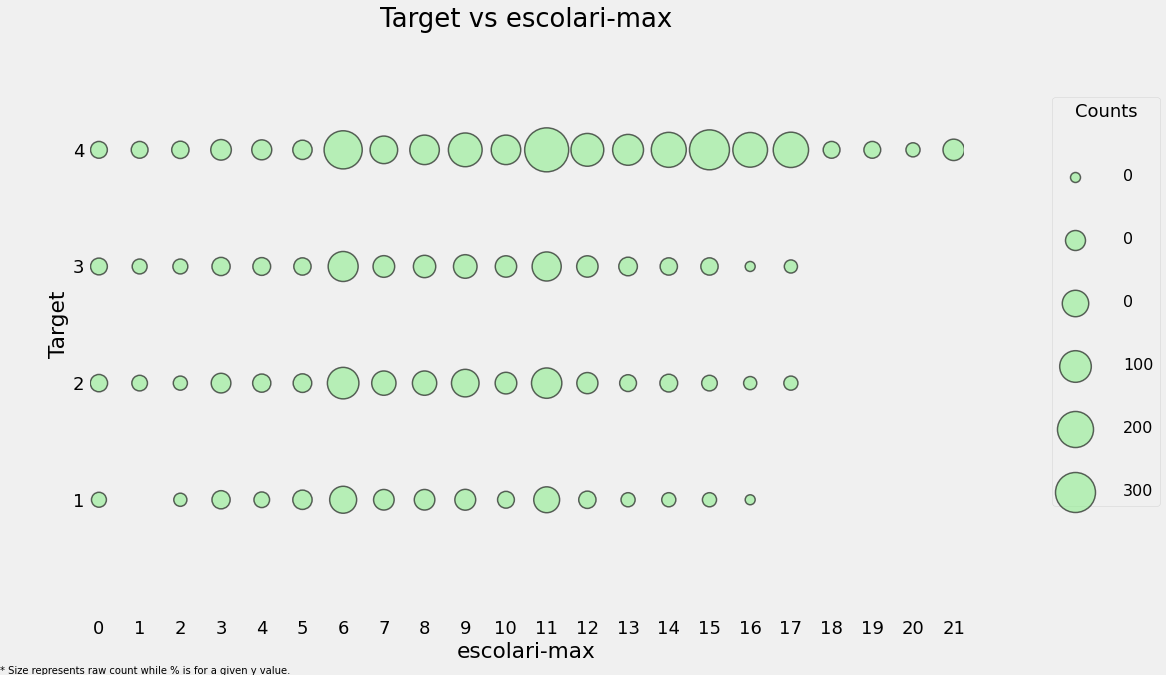

In [121]:
plot_categoricals('escolari-max', 'Target', final, annotate=False);

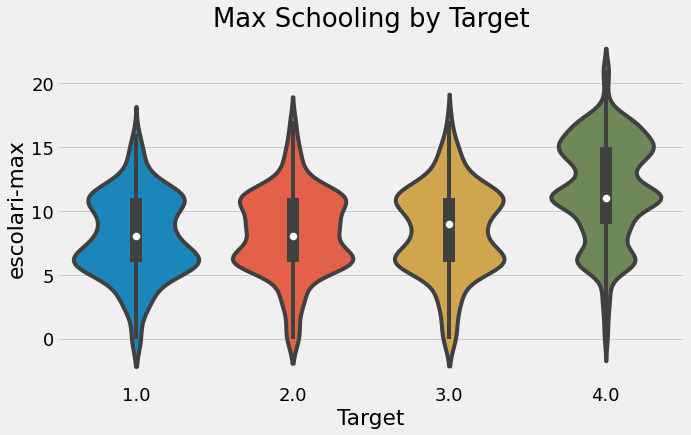

In [122]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

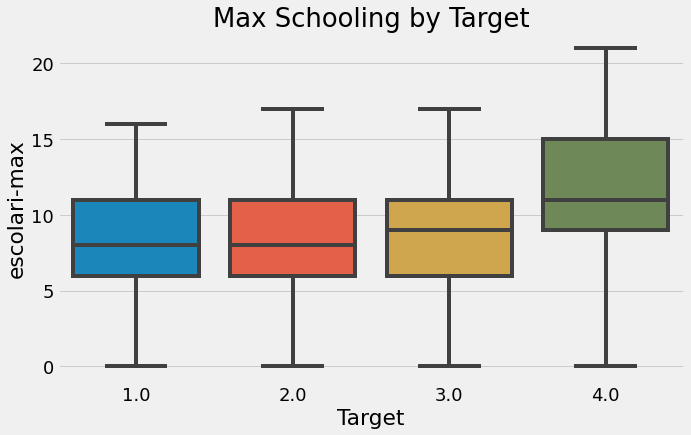

In [123]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

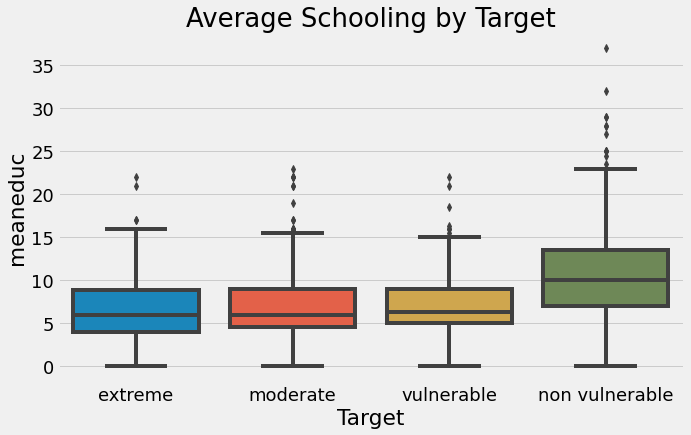

In [124]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'meaneduc', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Average Schooling by Target');

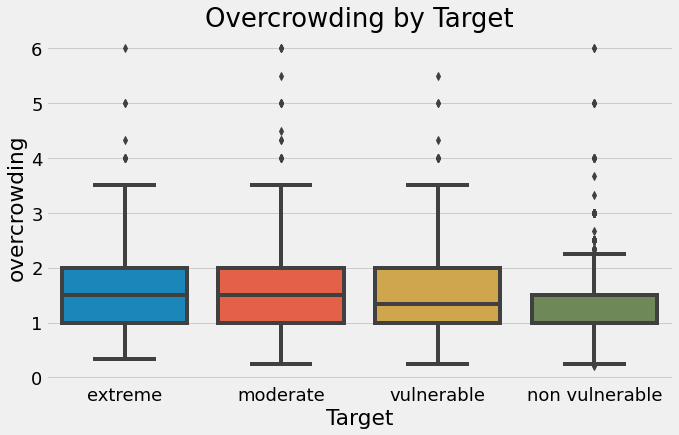

In [125]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'overcrowding', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Overcrowding by Target');

유용하게 쓰일 수 있는 또 다른 특징은 가장의 성별입니다. 자료를 종합했으니까 개인 차원의 데이터로 돌아가서 가장의 성별을 찾아봐야 할 것 같습니다.


In [126]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on = 'idhogar', how = 'left').rename(columns = {'female': 'female-head'})

In [127]:
final.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

가장이 여성인 가구는 약간 더 심각한 빈곤 수준을 가질 가능성이 있는 것으로 보입니다.

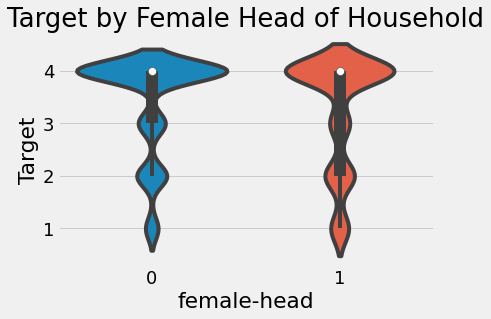

In [128]:
sns.violinplot(x = 'female-head', y = 'Target', data = final);
plt.title('Target by Female Head of Household');

또한 여성 가장이 있는지 없는지에 따라 평균 교육의 차이를 살펴볼 수 있습니다.


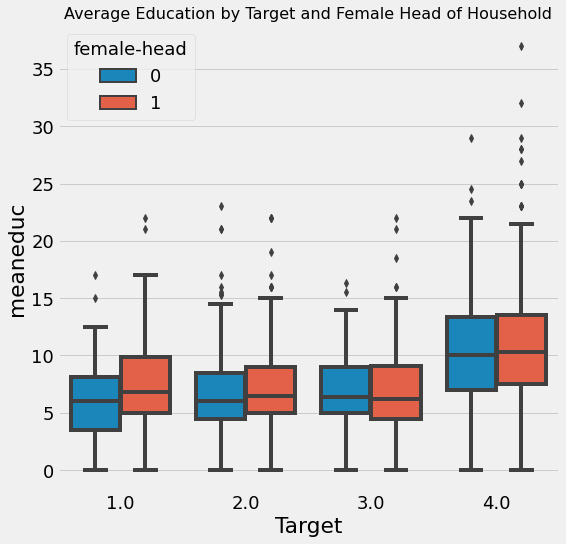

In [129]:
plt.figure(figsize = (8, 8))
sns.boxplot(x = 'Target', y = 'meaneduc', hue = 'female-head', data = final);
plt.title('Average Education by Target and Female Head of Household', size = 16);

타겟의 모든 가치를 보면 여성 가장이 있는 가구의 교육 수준이 더 높은 것으로 보입니다. 하지만, 우리는 전반적으로 여성 가장이 있는 가정이 심각한 빈곤을 겪을 가능성이 더 높다는 것을 보았습니다.


In [130]:
final.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

mean  count
female-head                 
0            8.968025   6384
1            9.237013   3903

전반적으로, 여성 가장이 있는 가구의 평균 학력은 남성 가장보다 약간 높습니다. 어떻게 해야 할지 잘 모르겠는데, 저한테는 맞는 것 같아요.


# Machine Learning Modeling

피쳐 엔지니어링/구성이 완료되면 기계 학습을 시작할 수 있습니다! 우리의 모든 데이터(교육과 테스트 모두)는 각 가정에 대해 집계되므로 모델에서 직접 사용할 수 있습니다. 먼저 모델링 과정을 보여드리기 위해 Scikit-Learn에서 지원되는 랜덤 포레스트 분류기를 사용하겠습니다. 이것으로는 리더보드의 정상에 오르지 못하겠지만, 기준선을 세울 수 있을 겁니다. 나중에 강력한 그라데이션 부스팅 머신(Gradient Boosting Machine)을 포함한 여러 가지 다른 모델을 사용해 보겠습니다.

모델을 평가하기 위해 교육 데이터에 대해 10배 이상의 교차 검증을 사용할 것입니다. 이것은 본질적으로 훈련 데이터의 서로 다른 분할을 사용하여 모델을 10번 훈련하고 테스트합니다. 10배 교차 검증은 테스트 세트에서 모델의 성능을 추정하는 데 효과적인 방법입니다. 우리는 폴드 사이의 점수가 얼마나 변화하는지 표준 편차와 교차 검증에서의 평균 성능을 보고 싶습니다. F1 매크로 측도를 사용하여 성능을 평가합니다.



In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [132]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8))) # float64 -> uint8 -> list -> np.array

# Extract the training data
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# Submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

서로 다른 모형을 비교하기 때문에 피쳐의 크기를 조정하려고 합니다(각 열의 범위를 0과 1 사이로 제한). 많은 앙상블 모델의 경우 이것이 필요하지 않지만, KNearest Neighbors 또는 Support Vector Machine과 같이 거리 메트릭에 의존하는 모델을 사용할 때는 형상 배율이 절대적으로 필요합니다. 여러 모델을 비교할 때는 기능을 확장하는 것이 항상 가장 안전합니다. 또한 결측값을 형상의 중위수로 귀속시킵니다.

결측값을 귀속시키고 피쳐를 한 번에 확장하기 위해 파이프라인을 만들 수 있습니다. 이 값은 교육 데이터에 적합하며 교육 및 테스트 데이터를 변환하는 데 사용됩니다.


In [133]:
# 데이터 변환
features = list(train_set.columns)

pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

데이터는 결측값이 없으며 0에서 1 사이로 크기가 조정됩니다. 즉, 모든 Scikit-Learn 모델에서 직접 사용할 수 있습니다.


In [134]:
model = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3436 with std = 0.0449


그 점수는 좋지는 않지만, 기준점이 될 것이고 우리에게 발전의 여지를 많이 남길 것입니다!

## Feature Importances

트리 기반 모델을 사용하면 모델에 있는 피쳐의 유용성에 대한 상대적 순위를 보여주는 피쳐 중요도를 살펴볼 수 있습니다. 이는 변수를 분할에 사용한 노드의 불순도 감소의 합을 나타내지만 절대값에 크게 신경 쓸 필요는 없습니다. 대신 상대적인 점수에 초점을 맞추도록 하겠습니다.

기능 중요도를 보려면 전체 교육 세트에 대한 모델을 교육해야 합니다. 교차 검증은 피쳐 중요도를 반환하지 않습니다.




In [135]:
model.fit(train_set, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

feature  importance
0       hacdor    0.000737
1       hacapo    0.000467
2         v14a    0.000498
3       refrig    0.002304
4  paredblolad    0.007034

In [136]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

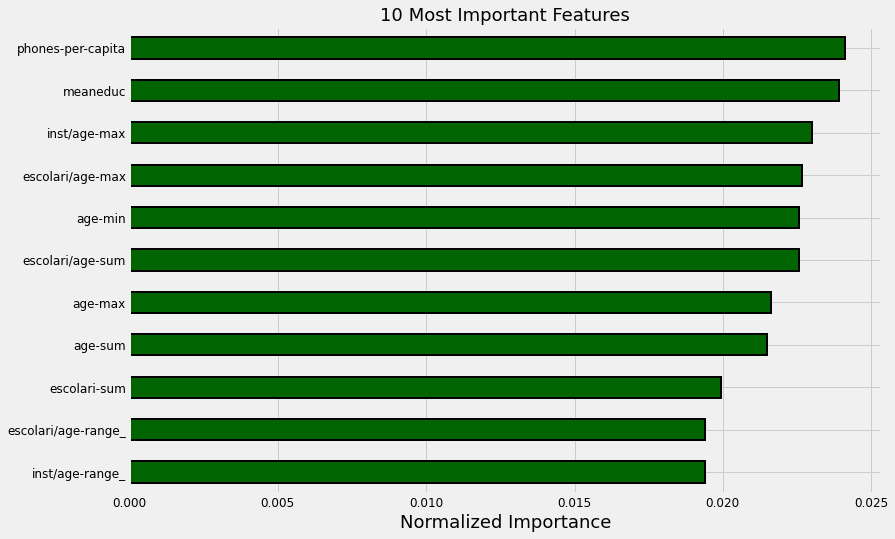

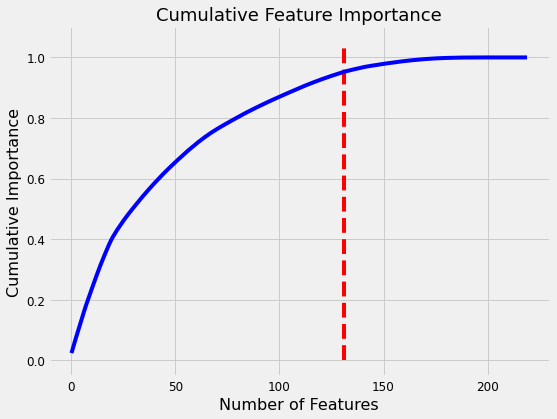

131 features required for 95% of cumulative importance.


In [137]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

교육이 최고입니다! 가장 중요한 변수는 가구 내 평균 교육량이고, 그 다음으로 가구 내 누구의 최대 교육량입니다. 이 변수들이 높은 상관 관계(공선)가 있는 것 같으므로 데이터에서 변수 중 하나를 제거해야 할 수도 있습니다. 다른 가장 중요한 특징은 우리가 만든 변수와 이미 데이터에 존재했던 변수들의 조합입니다.

흥미로운 점은 우리가 180개 이상의 기능 중 중요도의 90%를 차지하는 106개 기능만 있으면 된다는 것입니다. 이는 일부 기능을 제거할 수 있음을 나타냅니다. 그러나 기능의 중요성은 기능의 어떤 방향이 중요한지 알려주지 않고(예를 들어, 교육을 더 많이 받거나 덜 받는 것이 더 심각한 빈곤으로 이어지는지 알 수 없음) 모델이 관련이 있다고 간주되는 기능만 알려줍니다.

In [138]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize = (12, 8))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

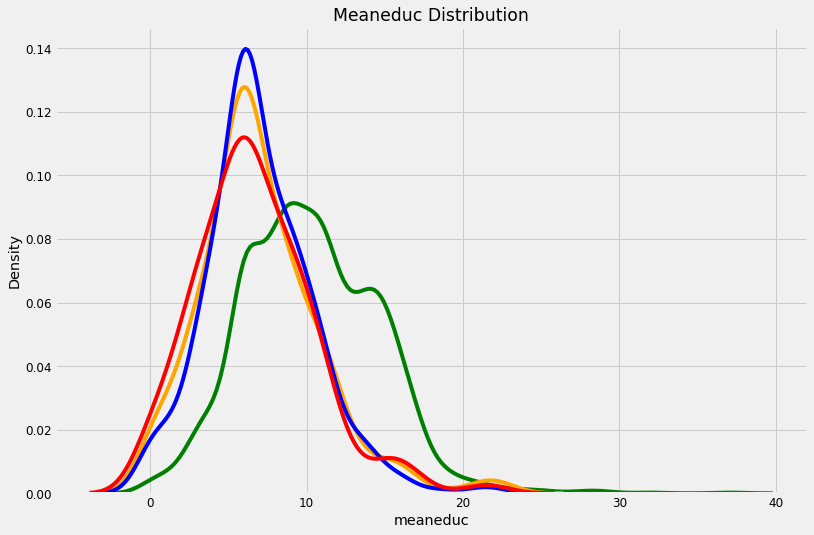

In [139]:
kde_target(final, 'meaneduc')

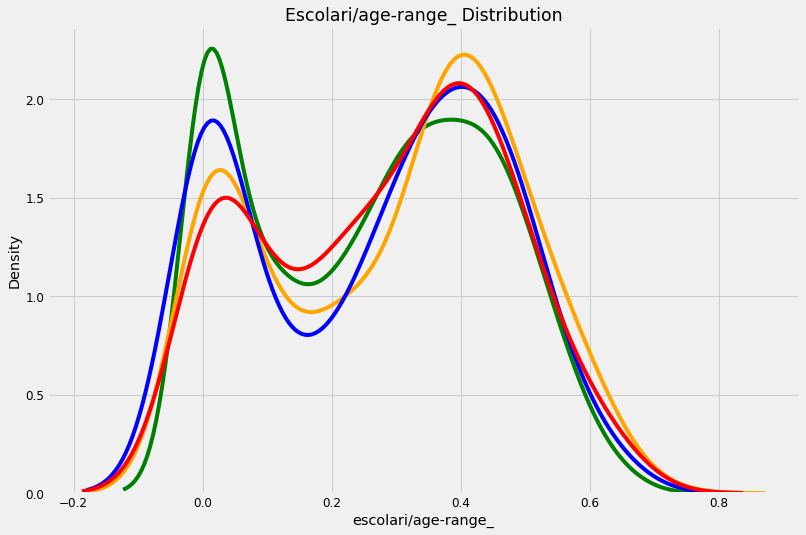

In [140]:
kde_target(final, 'escolari/age-range_')

# Model Selection

이제 좋은 기능들을 갖추었으니 모델링에 대해 알아보겠습니다. 우리는 이미 0.35의 최고의 매크로 F1을 제공하는 랜덤 포레스트 분류기라는 기본 모델을 시도했습니다. 그러나 머신러닝에서는 주어진 데이터 세트에 가장 적합한 모델을 미리 알 수 있는 방법이 없습니다. 다음 그림은 가우스 나이브 베이도 그레이디언트 부스팅 머신보다 성능이 뛰어난 몇 가지 문제가 있음을 보여줍니다. 이것은 Randal Olson의 머신러닝의 많은 점에 대해 논한 훌륭한 논문입니다.


![algorithm_comparison](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/algorithm_comparison.png)



이 그래프는 우리가 어떤 것이 가장 적합한지 알아보기 위해 여러 가지 다른 모델을 시도해야 한다는 것을 말해줍니다. 대부분의 사람들은 결국 경사로 부스팅 기계에 안주하게 되는데, 우리는 그것을 시도해 보겠지만, 지금은 다른 옵션들을 살펴보도록 하겠습니다. Scikit-Learn 설명서를 보면 말 그대로 수십 개(수백 개)의 멀티 클래스 머신러닝 모델이 있습니다. 꼭 다 먹어볼 필요는 없지만, 선택지에서 시식해봐야 해요.

우리가 원하는 것은 모델을 평가할 수 있는 함수를 작성하는 것입니다. 우리는 이미 대부분의 코드를 작성했기 때문에 이것은 매우 간단할 것입니다. 랜덤 포레스트 분류기 외에도 8가지 Scikit-Learn 모델을 사용해 보겠습니다. 다행히도 이 데이터 세트는 비교적 작아서 모델을 통해 빠르게 반복할 수 있습니다. 우리는 결과를 저장할 데이터 프레임을 만들 것이고 함수는 각 모델의 데이터 프레임에 행을 추가할 것입니다.







In [141]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [142]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [143]:
model_results = cv_model(train_set, train_labels, LinearSVC(), 'LSVC', model_results)

10 Fold CV Score: 0.2846 with std: 0.04058


이는 목록을 지우는 하나의 모델입니다(실제 성능을 향상시킬 수 있도록 하이퍼 파라미터 조정을 수행하지는 않았습니다).


In [144]:
model_results = cv_model(train_set, train_labels, 
                         GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.19356 with std: 0.0394


그 공연은 매우 형편없어요. Gradient Boosting Machine을 능가할 수 있는 문제가 있기는 하지만 가우스 네이브 베이즈 방법을 다시 검토할 필요는 없다고 생각합니다.


In [145]:
model_results = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.3258 with std: 0.04728


다층 퍼셉트론 (심층 신경 네트워크)은 괜찮은 성능을 가지고 있습니다. 네트워크를 하이퍼 파라미터로 튜닝할 수 있는 경우 이 옵션이 될 수 있습니다. 그러나, 제한된 양의 데이터는 일반적으로 효과적으로 학습하기 위해 수십만 개의 예제가 필요하기 때문에 신경망의 문제가 될 수 있습니다.


In [146]:
model_results = cv_model(train_set, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

10 Fold CV Score: 0.31535 with std: 0.05985


UserWarnings를 필터링하지 않고 LinearDiscrigant Analysis를 실행하면 "변수는 동일선상에 있습니다"라는 메시지가 많이 표시됩니다. 그러면 일부 동일선 피쳐를 제거하려는 힌트가 될 수 있습니다! 점수가 랜덤 포레스트와 비슷하기 때문에 동일선 변수를 제거한 후 이 모델을 다시 시도해보는 것이 좋을 것 같습니다.


In [147]:
model_results = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27979 with std: 0.03539


선형 모형(능선 정규화 포함)이 놀라울 정도로 잘 작동합니다. 이는 단순한 모델이 이 문제에 큰 도움이 될 수 있음을 나타낼 수 있습니다(그러나 더 강력한 방법을 사용하게 될 수도 있습니다.


In [148]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.34834 with std: 0.0448

KNN with 10 neighbors

10 Fold CV Score: 0.31581 with std: 0.03657

KNN with 20 neighbors

10 Fold CV Score: 0.30209 with std: 0.04095


의사 결정 트리의 앙상블을 사용하는 랜덤 포리스트의 변형인 ExtraTreeClassifier를 한 번 더 살펴보겠습니다.


In [149]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.32022 with std: 0.0411


# Comparing Model Performance

데이터 프레임의 모델링 결과를 사용하여 어떤 모델이 가장 잘 수행되는지 확인할 수 있습니다.


In [150]:
model_results = cv_model(train_set, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.3436 with std: 0.04488


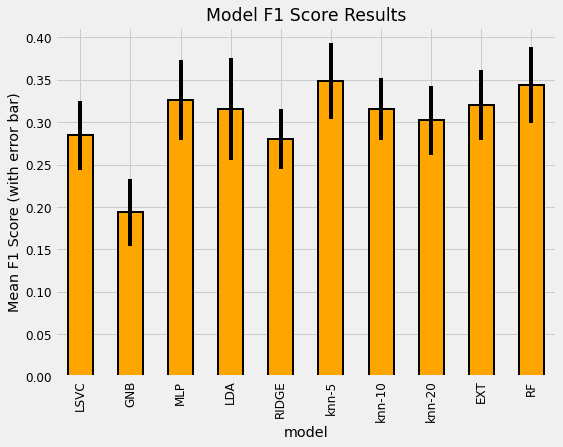

In [151]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

랜덤 포레스트는 개봉 즉시 사용이 가능하기 때문에 가장 가능성이 높은 것으로 보입니다. 하이퍼 파라미터를 조정하지 않았기 때문에 모델 간의 비교가 완벽하지는 않지만, 이러한 결과는 Gradient Boosting Machine을 포함한 트리 기반 앙상블 방법이 구조화된 데이터 세트에서 매우 잘 수행된다는 것을 발견한 다른 많은 Kaggle 경쟁업체의 결과를 반영합니다. 하이퍼파라미터 성능은 머신러닝 모델의 성능을 향상시키지만 모든 모델에 대해 가능한 모든 설정 조합을 시도할 시간은 없습니다. 아래 그래프(Randal Olson의 논문 참조)는 Scikit-Learn의 하이퍼 파라미터 튜닝 대 기본값을 보여줍니다.



![hyperparameter_improvement](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/hyperparameter_improvement.png)

지금은 랜덤 포레스트가 가장 좋습니다. 나중에 Scikit-Learn에는 구현되지 않았지만 Gradient Boosting Machine을 사용하는 방법에 대해 알아보겠습니다. 대신 더 강력한 LightGBM 버전을 사용할 것입니다. 그럼 이번에는 랜덤 포레스트로 제출하겠습니다.


# Making a Submission

제출하기 위해서는 테스트 자료가 필요합니다. 다행히도, 열차 데이터와 동일한 방식으로 테스트 데이터가 포맷되어 있습니다.

테스트 제출 양식은 아래와 같습니다. 가구당 예측을 하고 있지만 실제로는 개인당 한 줄(아이디로 확인)이 필요한데 가장에 대한 예측만 점수가 매겨집니다.


submission_base는 각 개인에 대해 "예측"을 가져야 하므로 테스트 세트의 모든 개인을 포함하지만 test_ids는 가장의 idhogar만 포함합니다. 예측 시 각 가구에 대해서만 예측한 다음 예측 데이터 프레임을 가구 ID(idhogar)의 모든 개인과 병합합니다. 이렇게 하면 한 가정의 모든 사람에게 동일한 값으로 타겟이 설정됩니다. 가장이 없는 시험 가구에 대해서는 점수가 매겨지지 않기 때문에 우리는 이 예측을 4로 설정할 수 있습니다.


In [152]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

아래 기능은 모델, 교육 세트, 교육 라벨 및 테스트 세트를 가져와 다음 연산을 수행합니다.

- 적합치를 사용하여 교육 데이터에 대한 모형을 교육합니다.
- 예측을 사용하여 검정 데이터를 예측합니다.
- 저장하여 경쟁사에 업로드할 수 있는 제출 데이터 프레임을 작성합니다.


In [153]:
def submit(model, train, train_labels, test, test_ids):
    """Train and test a model on the dataset"""
    
    # Train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions})

     # Make a submission dataframe
    submission = submission_base.merge(predictions, 
                                       on = 'idhogar',
                                       how = 'left').drop(columns = ['idhogar'])
    
    # Fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission 

In [154]:
rf_submission = submit(RandomForestClassifier(n_estimators = 100, 
                                              random_state=10, n_jobs = -1), 
                         train_set, train_labels, test_set, test_ids)

rf_submission.to_csv('rf_submission.csv', index = False)

이러한 예측은 대회에 제출되었을 때 0.370점을 받았습니다.


# Feature Selection

모델 성능을 향상시킬 수 있는 한 가지 방법은 피쳐 선택입니다. 이것은 우리 모델에 가장 유용한 기능만을 유지하기 위해 노력하는 과정입니다. "가장 유용한"은 많은 다른 것들을 의미할 수 있고, 가장 중요한 특징들을 선택하기 위한 많은 휴리스틱들이 있습니다. 이 노트북의 피쳐 선택을 위해 먼저 상관관계가 0.95보다 큰 열을 제거한 다음(기능 엔지니어링 중에 이미 이 중 일부를 수행함) Scikit-Learn 라이브러리로 재귀 피쳐 제거를 적용하겠습니다.

먼저 상관 관계입니다. 0.95는 임의의 임계값입니다. 자유롭게 값을 변경하고 성능이 어떻게 변경되는지 확인하십시오.


In [155]:
train_set = pd.DataFrame(train_set, columns = features)

# Create correlation matrix
corr_matrix = train_set.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'elec', 'v18q-count', 'female-sum']

In [156]:
train_set = train_set.drop(columns = to_drop)
train_set.shape

(2973, 216)

In [157]:
test_set = pd.DataFrame(test_set, columns = features)
train_set, test_set = train_set.align(test_set, axis = 1, join = 'inner')
features = list(train_set.columns)

## Recursive Feature Elimination with Random Forest

Sklearn의 RFECV는 교차 검증을 통한 재귀 기능 제거를 나타냅니다. 선택기는 피쳐가 중요한 모델을 반복적으로 사용하여 작동합니다. 각 반복 시 일부 피쳐 또는 설정된 피쳐 수가 제거됩니다. 교차 유효성 검사 점수가 더 이상 향상되지 않을 때까지 반복됩니다.

선택기 객체를 만들기 위해 모델, 각 반복 시 제거할 피쳐 수, 교차 검증 접힘, 사용자 지정 점수 매기기 및 선택을 안내하는 다른 매개 변수를 전달합니다.


In [158]:
from sklearn.feature_selection import RFECV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

# Create the object
selector = RFECV(estimator, step = 1, cv = 3, scoring= scorer, n_jobs = -1)

그런 다음 다른 sklearn 모델과 마찬가지로 선택기를 교육 데이터에 맞춥니다. 이렇게 하면 교차 유효성 검사 점수가 더 이상 향상되지 않을 때까지 피쳐 선택이 계속됩니다.


In [159]:
selector.fit(train_set, train_labels)

RFECV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=10),
      n_jobs=-1, scoring=make_scorer(f1_score, average=macro))

우리는 각 반복에 대한 훈련 점수를 보기 위해 객체를 조사할 수 있습니다. 다음 코드는 검증 점수 대 교육에 대한 기능 수를 표시합니다.


44

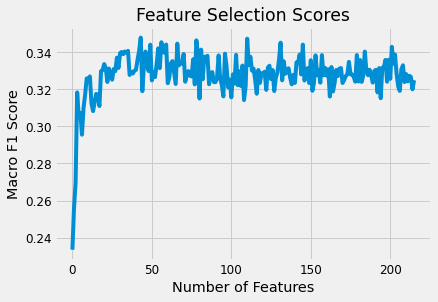

In [160]:
plt.plot(selector.grid_scores_);

plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
selector.n_features_

44개까지 기능을 추가하면 점수가 향상되는 것을 알 수 있습니다. 선택기에 따르면 이 개수가 최적의 피쳐 개수입니다.

각 형상의 순위는 훈련된 객체를 검사하여 확인할 수 있습니다. 이는 기본적으로 반복에 걸쳐 평균화된 기능의 중요성을 나타냅니다. 형상은 동일한 순위를 공유할 수 있으며 순위가 1인 형상은 유지됩니다.


In [161]:
rankings = pd.DataFrame({'feature': list(train_set.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
rankings.head(10)

feature  rank
99    rent-per-capita     1
197      escolari-max     1
68             edjefa     1
91               roof     1
131  estadocivil7-sum     1
139   parentesco3-sum     1
67             edjefe     1
66         dependency     1
65               v2a1     1
77               r4m3     1

마지막으로 특징을 선택한 다음 교차 검증으로 평가합니다.


In [162]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [163]:
# Convert back to dataframe
selected_features = train_set.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)

In [164]:
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

10 Fold CV Score: 0.36629 with std: 0.04023


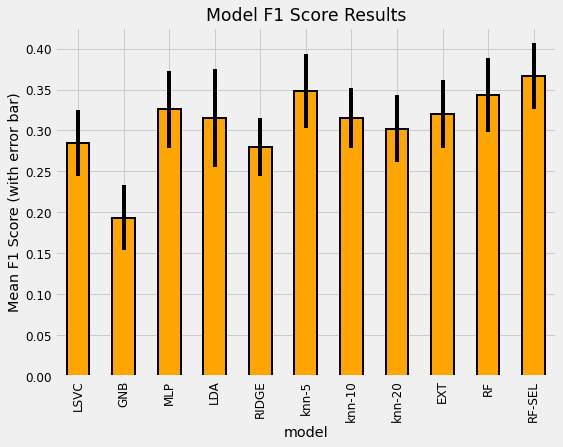

In [165]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                 edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

선택된 특징을 가진 모형이 교차 검증에서 약간 더 우수합니다. 다음 모델인 Gradient Boosting Machine에서 사용할 수 있도록 두 가지 기능을 모두 유지할 수 있습니다.


# Upgrading Our Model: Gradient Boosting Machine

랜덤 포레스트 이용 후 적절한 점수를 얻으면 이제 Gradient Boosting Machine을 이용할 차례입니다. Kaggle에 시간을 투자하면 데이터가 구조화되고 데이터 세트가 그리 크지 않은(관측치 백만 개 미만) 경쟁에서 GBM(Gradient Boosting Machine)이 높은 비율을 차지한다는 것을 알 수 있습니다.

여기서는 너무 자세히 설명하지 않고, 구현에 초점을 맞추겠습니다. Scikit-Learn, XGBoost 및 CatBoost에도 옵션이 있지만 LightGBM에서 GBM을 사용합니다. 처음 사용할 하이퍼 파라미터 세트는 다른 문제에도 적합하다고 판단한 것을 기반으로 합니다.

### Choosing Number of Estimators with Early Stopping

추정기 수('n_estimators' 또는 'num_boost_rounds'라고 하는 앙상블의 의사결정 트리 수)를 선택하려면 5배 교차 검증으로 조기 정지를 사용합니다. 이렇게 하면 매크로 F1 점수로 측정한 성능이 100번의 교육 라운드 동안 증가하지 않을 때까지 추정기가 계속 추가됩니다. 이 메트릭을 사용하려면 사용자 지정 메트릭을 정의해야 합니다.


In [166]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

# Light Gradient Boosting Machine Implementation

아래 기능은 Stratized Kfold 교차 검증을 통해 그라데이션 부스팅 기계를 교육하고 교육 데이터에 과적합을 방지하기 위해 조기 정지하는 기능을 구현합니다(이러한 상황이 계속 발생할 수 있음). 함수는 교차 검증을 통해 훈련을 수행하고 각 접힘의 확률에 대한 예측을 기록합니다. 어떻게 작동하는지 보려면 각 폴드의 예측값을 반환한 다음 경쟁사에 업로드할 수 있는 제출물을 반환해야 합니다.

Gradient Boosting Machine의 하이퍼 파라미터를 선택하는 것은 어려울 수 있으며 일반적으로 모델 최적화를 통해 수행됩니다. 이 노트에서는 이전의 문제에서 잘 작동하는 하이퍼 파라미터 세트를 사용할 것입니다(이러한 문제가 반드시 이 경쟁사 문제로 이어지는 것은 아님).

우리는 'n_estimator'를 10000으로 설정했지만 교차 검증 메트릭이 'early_stopping_rounds'에 대해 개선되지 않을 때 훈련 추정기를 종료하는 조기 중지를 사용하기 때문에 실제로 이 수에 도달하지는 않을 것입니다. 이 기능에는 많은 내용이 있으므로 자세히 읽어보십시오. ('%%capture'와 '%%capture'를 조합하여 '디스플레이'는 훈련 중 맞춤 정보를 보여주기 위해 사용되므로 훈련 중에 모든 LightGBM 정보를 볼 필요는 없습니다.)


In [167]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, 
              nfolds = 5, return_preds = False, hyp = None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances along with validation scores
    return submission, feature_importances, valid_scores

### Cross Validation with Early Stopping Notes

조기 중지를 사용한 교차 검증은 검증 점수가 개선되지 않는 것이 분명하면 모델 복잡성을 계속 추가할 수 없으므로 교육 세트에서 과적합을 방지하는 가장 효과적인 방법 중 하나입니다. 이 과정을 여러 번 반복하면 한 번 접을 때 발생하는 편향을 줄이는 데 도움이 됩니다. 또한 조기 정지를 통해 모델을 훨씬 더 빨리 교육할 수 있습니다. 전체적으로 __early stop with cross validation_은 Gradient Boosting Machine에서 추정기 수를 선택하는 가장 좋은 방법이며 구현을 지정할 때 기본 기술이 되어야 합니다.


In [168]:
%%capture --no-display
predictions, gbm_fi = model_gbm(train_set, train_labels, test_set, test_ids, return_preds=True)

'Fold 1, Validation Score: 0.39067, Estimators Trained: None'

KeyboardInterrupt: 

Gradient Boosting Machine의 힘을 여기서 확인할 수 있습니다! 교차 검증 점수는 우리가 이전에 했던 모든 것을 날려버립니다.

각 폴드에서 예측이 어떻게 진행되는지 이해하기 위해 예측 내용을 살펴보겠습니다.


In [ ]:
predictions.head()

각 폴드에 대해 '1, 2, 3, 4' 열은 각 '대상'에 대한 확률을 나타냅니다. "타겟"은 "확실성"을 가진 이들 중 최대치입니다. 우리는 5개의 접힘 모두에 대한 예측을 가지고 있기 때문에 접힘마다 각각의 '대상'에 대한 신뢰도를 그릴 수 있습니다.
